## Module installation

Install the following modules to run the notebook:   
* `pip install holidays`
* `conda install -c conda-forge xgboost`
* `pip install graphviz`
* `conda install -c conda-forge tensorflow`
* `conda install -c conda-forge keras`

In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import date
import holidays
import matplotlib.pyplot as plt
plt.style.use("bmh")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor,  RandomForestRegressor
import xgboost as xgb
import graphviz
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from itertools import chain, combinations
from tqdm.notebook import tqdm

## Import 

In [2]:
df_bonn = pd.read_pickle("data/df_bonn.pickle")
df_weather_bonn = pd.read_pickle("data/df_weather_bonn.pickle")
df_essen = pd.read_pickle("data/df_essen.pickle")
df_weather_essen = pd.read_pickle("data/df_weather_essen.pickle")

---

## Feature Selection

Demand on a given day $:=$ number of bike rentals on that day 

In [3]:
# Add holiday, semester and school columns
holiday=holidays.Germany(years=[2019],prov='NW')

def isHoliday(day):
    return int(day in holiday)

# Adding days of lecture (only weekdays and no holidays)
def isSemester(day):
    isSemester = ((date(2019,  4, 1) <= day < date(2019,  6, 10) or 
                  date(2019,  6, 15) <= day <= date(2019,  7, 12) or 
                  date(2019,  2, 1) == day) and 
                  day.weekday() < 5 and
                  day not in holiday)
    return int(isSemester)

# Adding days of school (only weekdays and no holidays)
def isSchool(day):
    isSchool = ((day < date(2019,  4, 15) or 
                day > date(2019,  4, 27)) and 
                date(2019,  6, 11) != day and
                day.weekday() < 5 and
                day not in holiday)
    return int(isSchool)

# Adding Karneval (Weiberfastnacht to Aschermittwoch)
def isKarneval(day):
    isKarneval = (date(2019,  2, 28) <= day <= date(2019,  3, 6))
    return int(isKarneval)

In [4]:
df_bonn["day"] = df_bonn["timestamp"].apply(lambda row: row.date())
df_bonn = df_bonn.drop(["timestamp"], axis=1)
df_demand_bonn = pd.DataFrame(df_bonn.groupby(["day"]).count()["b_number"])
df_demand_bonn = df_demand_bonn.rename(columns={"b_number": "demand"}) 
df_demand_bonn["isHoliday"] = df_demand_bonn.index.map(isHoliday)
df_demand_bonn["isWeekend"] = df_demand_bonn.index.map(lambda row: row.weekday()>=5).astype(int)
df_demand_bonn["isSemester"] = df_demand_bonn.index.map(isSemester)
df_demand_bonn["isSchool"] = df_demand_bonn.index.map(isSchool)
df_demand_bonn["isKarneval"] = df_demand_bonn.index.map(isKarneval)
df_demand_bonn

demand  isHoliday  isWeekend  isSemester  isSchool  isKarneval
day                                                                       
2019-02-01     904          0          0           1         1           0
2019-02-02     682          0          1           0         0           0
2019-02-03     624          0          1           0         0           0
2019-02-04     837          0          0           0         1           0
2019-02-05    1012          0          0           0         1           0
...            ...        ...        ...         ...       ...         ...
2019-06-26    3625          0          0           1         1           0
2019-06-27    3829          0          0           1         1           0
2019-06-28    4259          0          0           1         1           0
2019-06-29    3275          0          1           0         0           0
2019-06-30    2476          0          1           0         0           0

[147 rows x 6 columns]

In [5]:
df_essen["day"] = df_essen["timestamp"].apply(lambda row: row.date())
df_essen = df_essen.drop(["timestamp"], axis=1)
df_demand_essen = pd.DataFrame(df_essen.groupby(["day"]).count()["b_number"])
df_demand_essen = df_demand_essen.rename(columns={"b_number": "demand"}) 
df_demand_essen["isHoliday"] = df_demand_essen.index.map(isHoliday)
df_demand_essen["isWeekend"] = df_demand_essen.index.map(lambda row: row.weekday()>=5).astype(int)
df_demand_essen["isSemester"] = df_demand_essen.index.map(isSemester)
df_demand_essen["isSchool"] = df_demand_essen.index.map(isSchool)
df_demand_essen["isKarneval"] = df_demand_essen.index.map(isKarneval)
df_demand_essen

demand  isHoliday  isWeekend  isSemester  isSchool  isKarneval
day                                                                       
2019-02-01      57          0          0           1         1           0
2019-02-02      30          0          1           0         0           0
2019-02-03      29          0          1           0         0           0
2019-02-04      49          0          0           0         1           0
2019-02-05      60          0          0           0         1           0
...            ...        ...        ...         ...       ...         ...
2019-06-26     231          0          0           1         1           0
2019-06-27     272          0          0           1         1           0
2019-06-28     317          0          0           1         1           0
2019-06-29     174          0          1           0         0           0
2019-06-30     103          0          1           0         0           0

[147 rows x 6 columns]

---

### Weighting the weather data

Instead of simply aggregating each group of the dataframe of each city by `max()` or `avg()`, we use a weighted average:   
We group the weather dataframes by date and each of them has entries by hour, so each group contains data from multiple hours of that day. Each hour's value is weighted by the normalized bike rental activity of that hour. This means we put more weight on those hours of the day where bikes are generally more likely to be rented.

In [6]:
# Weather formatting
df_weather_bonn["day"] = df_weather_bonn["timestamp"].apply(lambda row: row.date())
df_weather_essen["day"] = df_weather_essen["timestamp"].apply(lambda row: row.date())

# WAVG: weighted AVG, where the weights are given by bike rental activity in each hour on an average day
weighting_bonn = df_bonn.groupby(["hour"]).count()["b_number"]
weighting_bonn = weighting_bonn/weighting_bonn.sum() # normalize to get a probability vector
weighting_essen = df_essen.groupby(["hour"]).count()["b_number"]
weighting_essen = weighting_essen/weighting_essen.sum() # normalize to get a probability vector

def weighted_average_bonn(group):
    return np.dot(group, weighting_bonn)

def weighted_average_essen(group):
    return np.dot(group, weighting_essen)

In [7]:
df_weather_bonn_wavg = df_weather_bonn.groupby(["day"]).agg(weighted_average_bonn)
df_weather_bonn_wavg = df_weather_bonn_wavg.rename(columns={c: f"WAVG({c})" for c in df_weather_bonn.columns})
df_weather_bonn_wavg = df_weather_bonn_wavg.drop(["WAVG(timestamp)"], axis=1)
df_weather_bonn_wavg 

WAVG(temperature_2m)  WAVG(dew_point_temperature_2m)  \
day                                                                
2019-02-01              2.589283                        0.190040   
2019-02-02              1.707427                        1.362507   
2019-02-03              2.170311                       -0.746181   
2019-02-04              2.497601                       -3.046916   
2019-02-05              3.547125                        1.223116   
...                          ...                             ...   
2019-06-26             28.361665                       17.564708   
2019-06-27             23.384853                        9.162896   
2019-06-28             23.014943                        9.474918   
2019-06-29             27.741437                       10.377776   
2019-06-30             27.836808                       16.056995   

            WAVG(relative_humidity)  WAVG(precipitation)  \
day                                                        
2019-02-01                84.655778             0.000537   
2019-02-02                97.521537             0.099593   
2019-02-03                81.691930             0.000000   
2019-02-04                67.962935             0.000000   
2019-02-05                84.980757             0.023813   
...                             ...                  ...   
2019-06-26                53.397946             0.000000   
2019-06-27                43.588095             0.000000   
2019-06-28                44.889360             0.000000   
2019-06-29                36.495337             0.000000   
2019-06-30                49.796694             0.000000   

            WAVG(has_precipitated)  WAVG(wind_velocity_10m)  \
day                                                           
2019-02-01                0.114506                 3.038463   
2019-02-02                0.870144                 1.851419   
2019-02-03                0.291645                 2.416769   
2019-02-04                0.089857                 3.977812   
2019-02-05                0.626654                 1.825829   
...                            ...                      ...   
2019-06-26                0.000000                 2.777642   
2019-06-27                0.000000                 3.073079   
2019-06-28                0.000000                 1.846362   
2019-06-29                0.000000                 2.476115   
2019-06-30                0.000000                 3.136759   

            WAVG(wind_direction_10m)  WAVG(mean_wind_speed_10m)  \
day                                                               
2019-02-01                124.923856                   3.207866   
2019-02-02                255.581138                   1.730363   
2019-02-03                301.408881                   2.574698   
2019-02-04                181.488745                   3.882295   
2019-02-05                162.644643                   1.833161   
...                              ...                        ...   
2019-06-26                309.156481                   2.717872   
2019-06-27                236.407469                   3.090089   
2019-06-28                241.325525                   1.815826   
2019-06-29                101.899238                   2.481449   
2019-06-30                276.905387                   3.016989   

            WAVG(mean_wind_direction_10m)  WAVG(air_pressure_station_level)  \
day                                                                           
2019-02-01                     129.995992                        971.119469   
2019-02-02                     237.622157                        979.431008   
2019-02-03                     306.407773                       1001.061444   
2019-02-04                     182.936981                       1007.202358   
2019-02-05                     164.391350                       1008.324046   
...                                   ...                               ...   
2019-06-26            

In [8]:
df_weather_essen_wavg = df_weather_essen.groupby(["day"]).agg(weighted_average_essen)
df_weather_essen_wavg = df_weather_essen_wavg.rename(columns={c: f"WAVG({c})" for c in df_weather_essen.columns})
df_weather_essen_wavg = df_weather_essen_wavg.drop(["WAVG(timestamp)"], axis=1)
df_weather_essen_wavg 

WAVG(temperature_2m)  WAVG(dew_point_temperature_2m)  \
day                                                                
2019-02-01              2.683164                       -0.400295   
2019-02-02              0.532974                       -0.603064   
2019-02-03              1.923608                       -1.470812   
2019-02-04              2.174682                       -3.438085   
2019-02-05              2.772528                        1.540757   
...                          ...                             ...   
2019-06-26             25.677072                       17.954211   
2019-06-27             20.462746                       10.403545   
2019-06-28             20.039355                        9.348817   
2019-06-29             27.438343                        9.887239   
2019-06-30             26.458117                       14.465990   

            WAVG(relative_humidity)  WAVG(precipitation)  \
day                                                        
2019-02-01                80.848372             0.046777   
2019-02-02                92.127370             0.670872   
2019-02-03                79.155059             0.000000   
2019-02-04                67.680672             0.000000   
2019-02-05                91.723530             0.017974   
...                             ...                  ...   
2019-06-26                63.280624             0.000000   
2019-06-27                54.699392             0.000000   
2019-06-28                52.606995             0.000000   
2019-06-29                36.463733             0.000000   
2019-06-30                47.954132             0.000000   

            WAVG(has_precipitated)  WAVG(wind_velocity_10m)  \
day                                                           
2019-02-01                0.230482                 3.095118   
2019-02-02                0.911214                 2.977361   
2019-02-03                0.000000                 2.432721   
2019-02-04                0.128875                 4.249907   
2019-02-05                0.170228                 2.650876   
...                            ...                      ...   
2019-06-26                0.000000                 3.344441   
2019-06-27                0.000000                 3.824685   
2019-06-28                0.000000                 3.215500   
2019-06-29                0.000000                 1.846199   
2019-06-30                0.000000                 3.668525   

            WAVG(wind_direction_10m)  WAVG(mean_wind_speed_10m)  \
day                                                               
2019-02-01                137.301511                   3.081340   
2019-02-02                 54.298441                   2.918799   
2019-02-03                308.121953                   2.419479   
2019-02-04                192.690664                   4.207247   
2019-02-05                202.853187                   2.613772   
...                              ...                        ...   
2019-06-26                231.906338                   3.264305   
2019-06-27                 85.601637                   3.806308   
2019-06-28                 51.835310                   3.354012   
2019-06-29                148.374165                   1.822206   
2019-06-30                259.647866                   3.578282   

            WAVG(mean_wind_direction_10m)  WAVG(air_pressure_station_level)  \
day                                                                           
2019-02-01                     140.552579                        971.989027   
2019-02-02                      44.114850                        980.884608   
2019-02-03                     313.163185                       1001.828357   
2019-02-04                     194.832360                       1007.154361   
2019-02-05                     205.229639                       1008.878421   
...                                   ...                               ...   
2019-06-26            

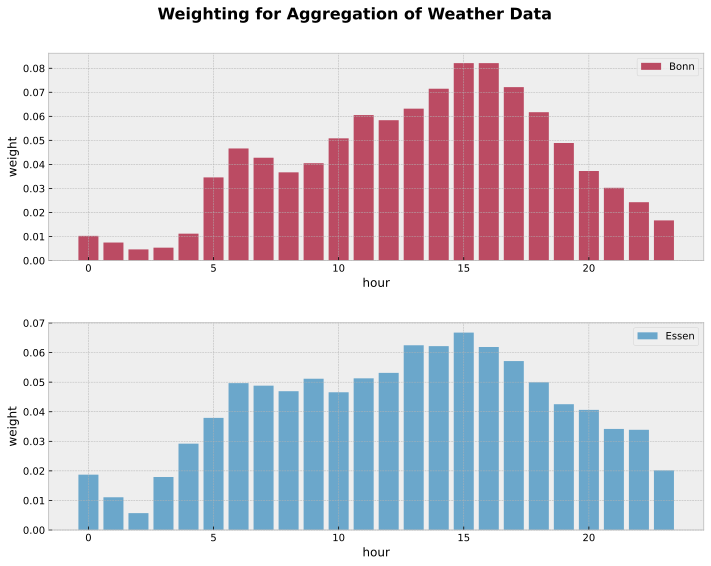

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 8))
# Bonn
ax1.bar(range(24), weighting_bonn, alpha=0.7, color='C1')
ax1.set_xlabel("hour")
ax1.set_ylabel("weight")
ax1.legend(['Bonn'])

# Essen
ax2.bar(range(24), weighting_essen, alpha=0.7)
ax2.set_xlabel("hour")
ax2.set_ylabel("weight")
ax2.legend(['Essen'])

fig.tight_layout()
fig.suptitle("Weighting for Aggregation of Weather Data", fontweight="bold", fontsize=16)
fig.subplots_adjust(top=0.9, hspace=0.3)

In [10]:
# Join demand and weather data (Bonn)
df_bonn = df_demand_bonn.join(df_weather_bonn_wavg, on="day", how="outer")
df_bonn = df_bonn[df_bonn.index.notna()] # remove entries where data is NaT
df_bonn = df_bonn.drop(["day"], axis=1)

# Join demand and weather data (Essen)
df_essen = df_demand_essen.join(df_weather_essen_wavg, on="day", how="outer")
df_essen = df_essen[df_essen.index.notna()] # remove entries where data is NaT
df_essen = df_essen.drop(["day"], axis=1)

---

### Feature selection criteria

To select suitable features for our regression models we first examined the correlation among the features (especially `demand`).

In [11]:
# Plot a simple linear regression between demand and every other feature
def plot_all_features(city):
    df = df_bonn if city=="Bonn" else df_essen
    for i, feature in enumerate(df_bonn.columns[1:]):
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title(f"{feature} vs Demand", fontsize=16, fontweight="bold", pad=20)
        ax.set_xlabel(feature)
        ax.set_ylabel("demand")
        ax.scatter(df[feature], df["demand"], marker="x", label="Observation on a specific day")
        
        # Simple linear regression
        df_dropped = df[[feature, "demand"]].dropna() 
        X = pd.DataFrame(df_dropped[feature])
        y = df_dropped["demand"]
        model = LinearRegression()
        model.fit(X, y)
        x_space = np.linspace(df[feature].min(), df[feature].max(), 100).reshape(100, 1)
        y_pred = model.predict(x_space)
        ax.plot(x_space, y_pred, c="red", label="Linear Regression")
        ax.legend(loc="lower right")

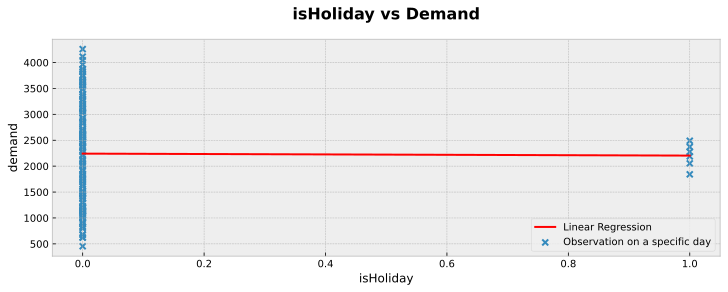

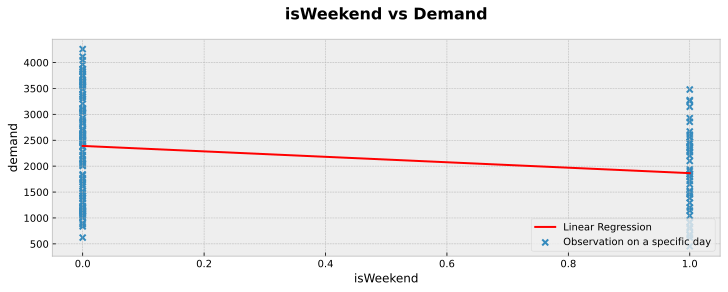

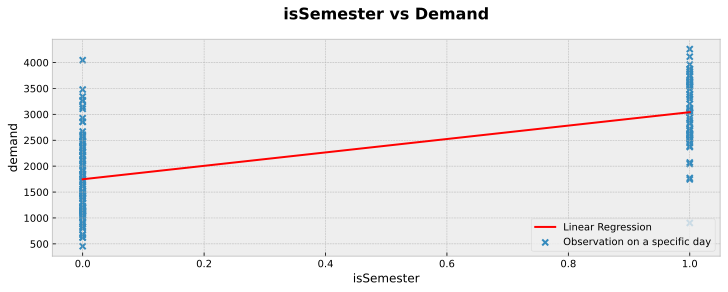

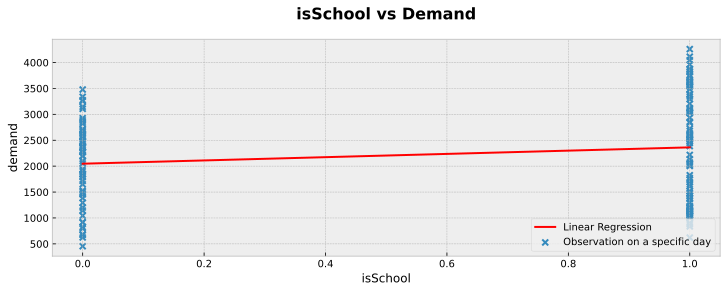

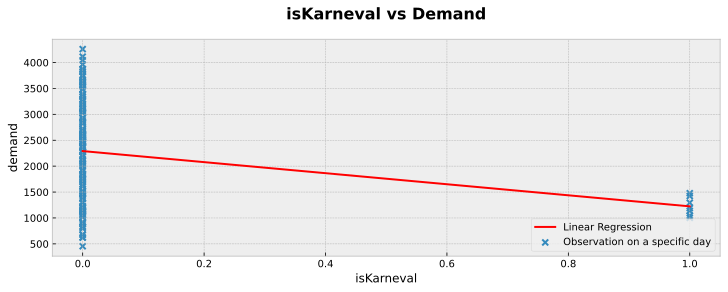

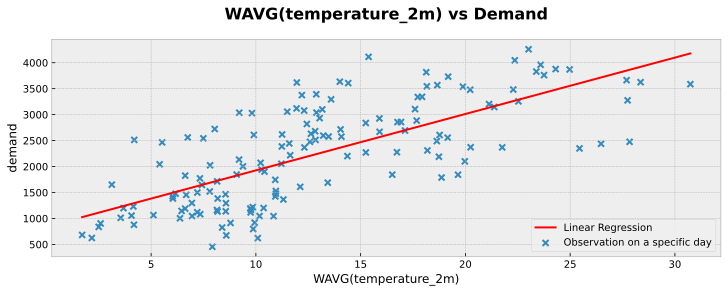

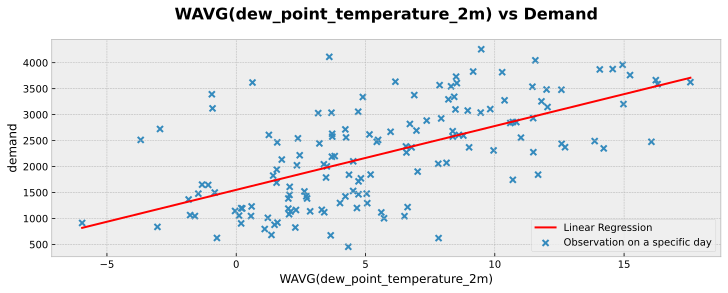

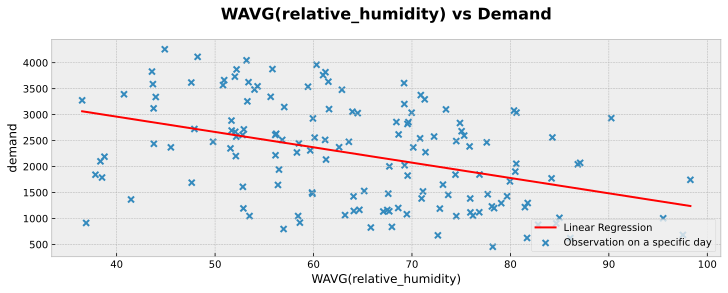

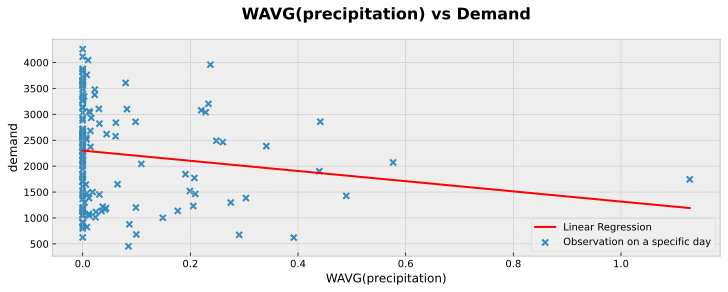

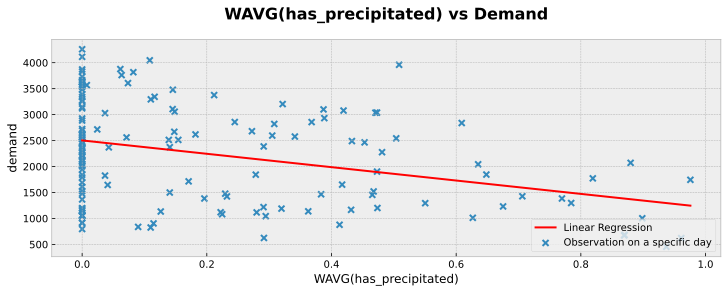

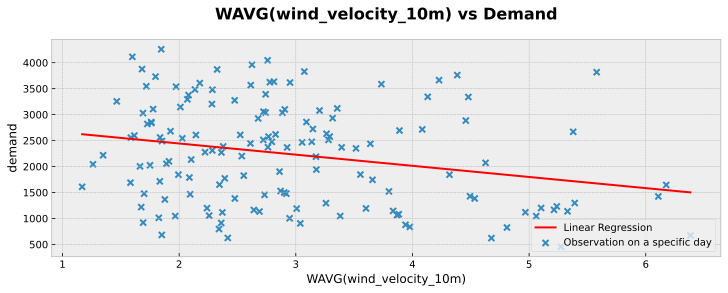

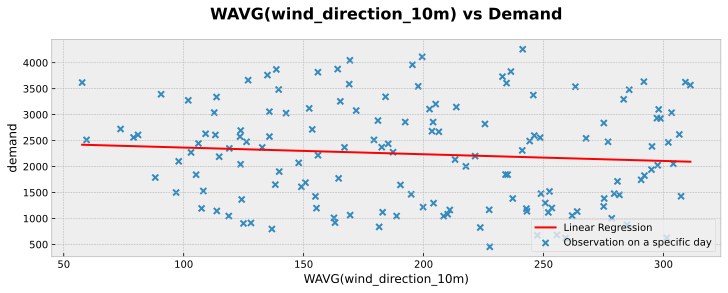

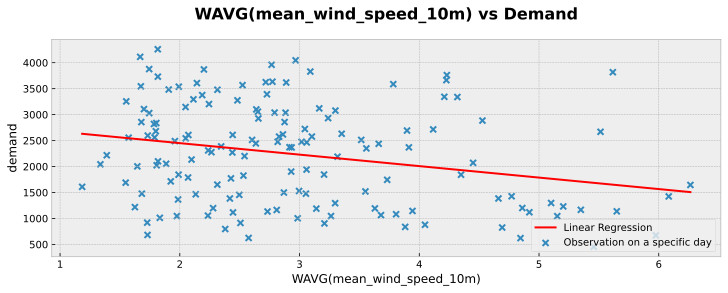

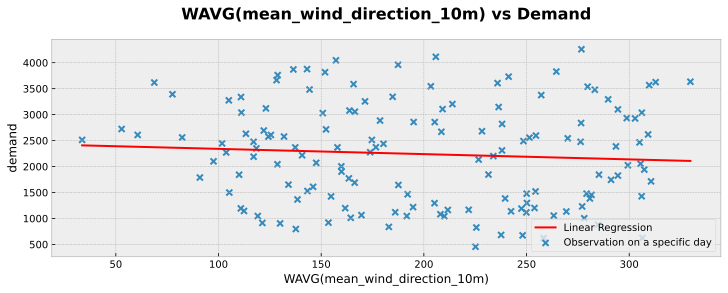

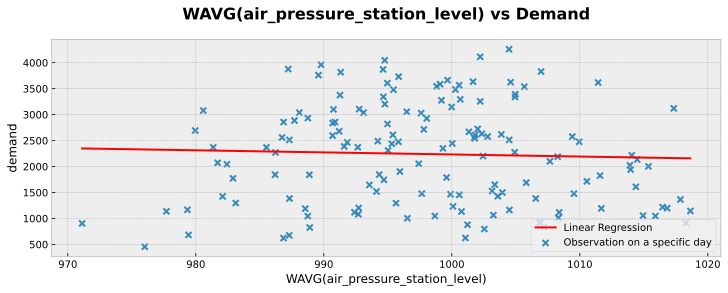

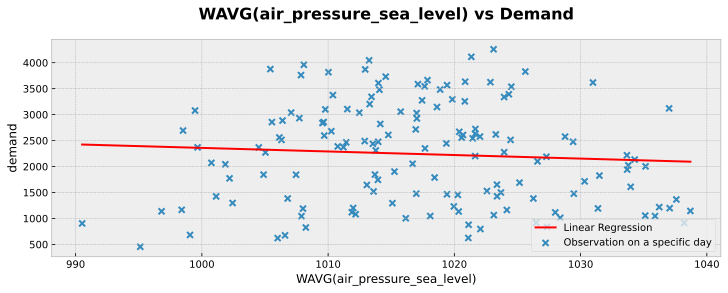

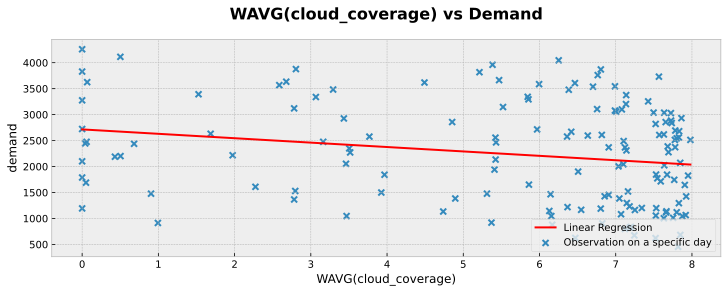

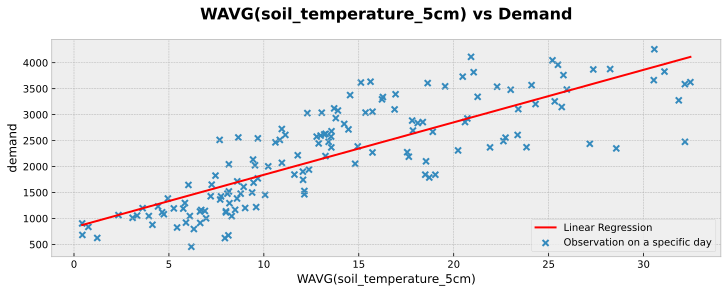

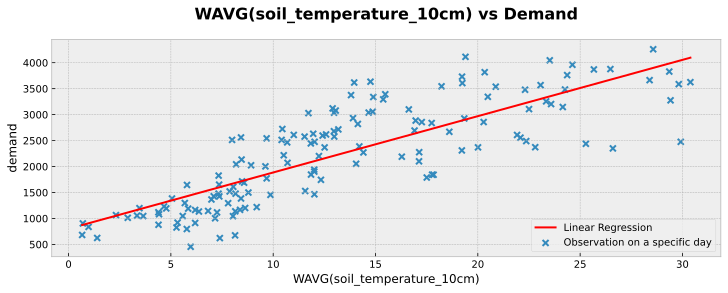

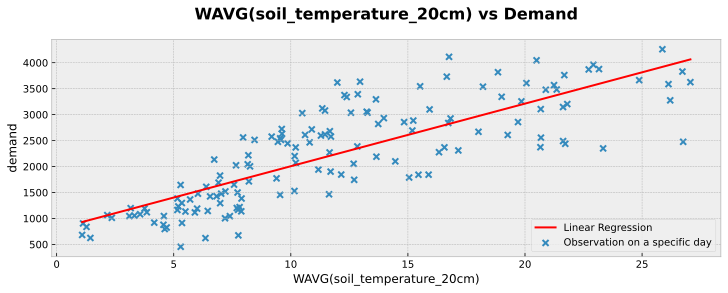

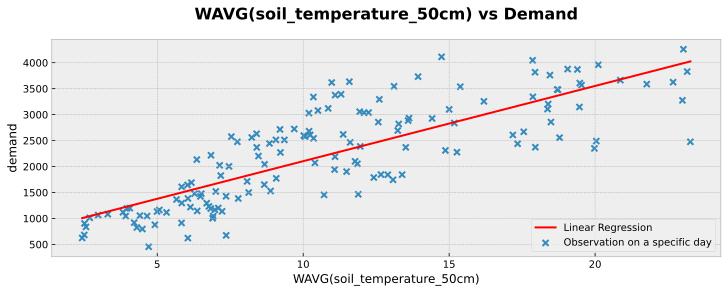

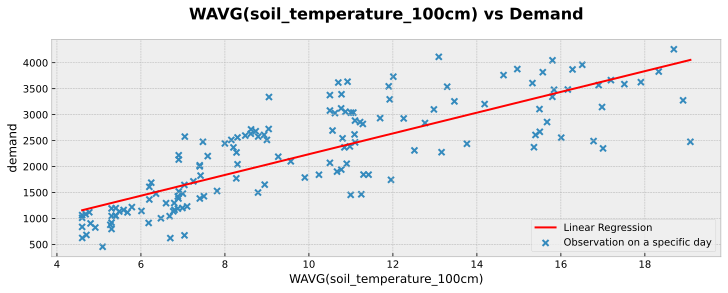

In [12]:
plot_all_features("Bonn")

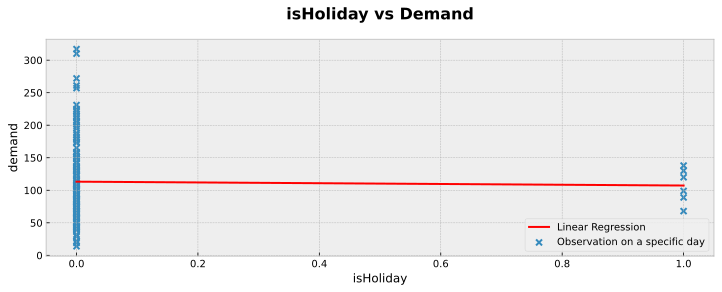

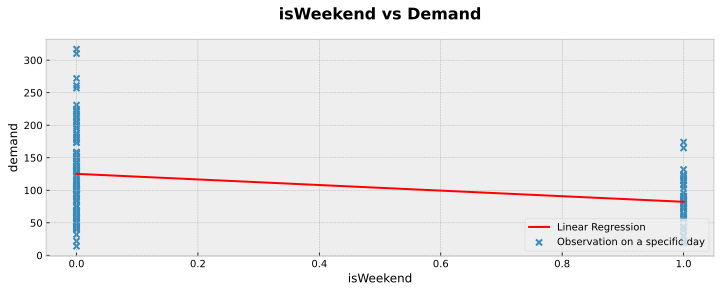

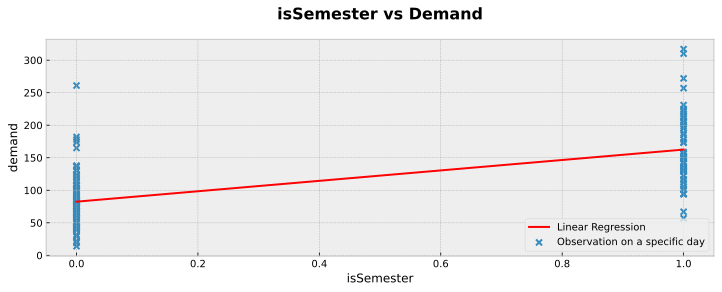

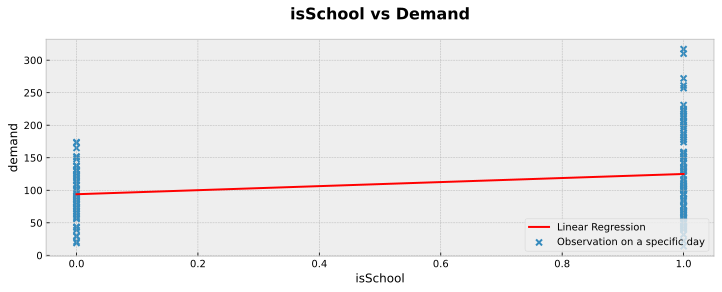

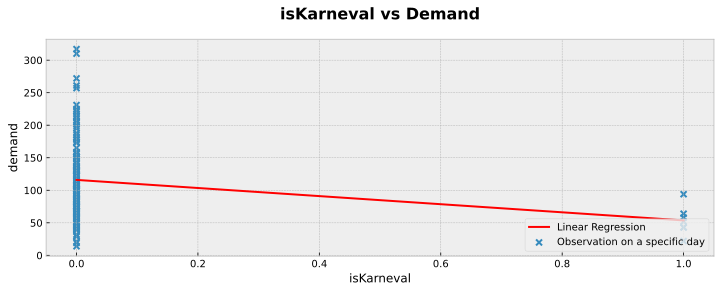

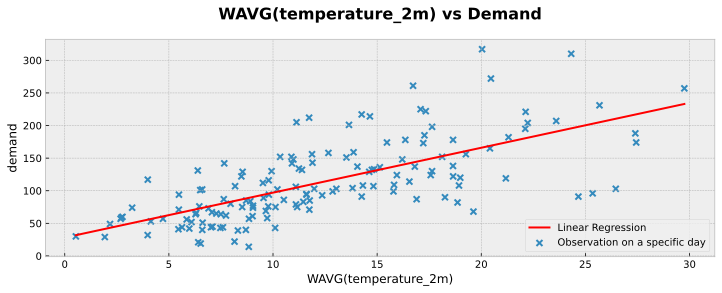

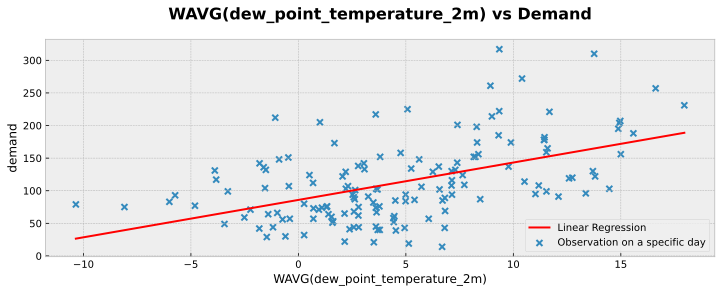

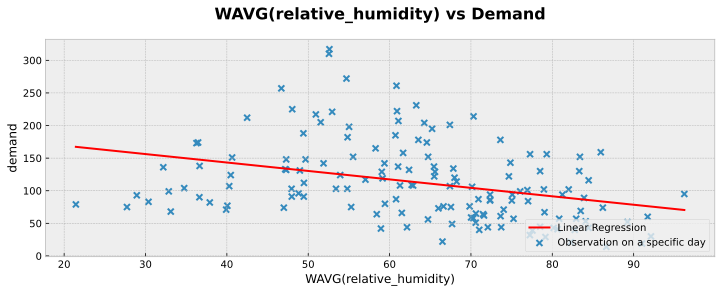

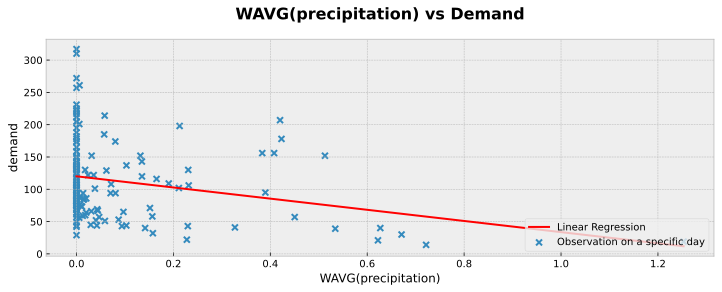

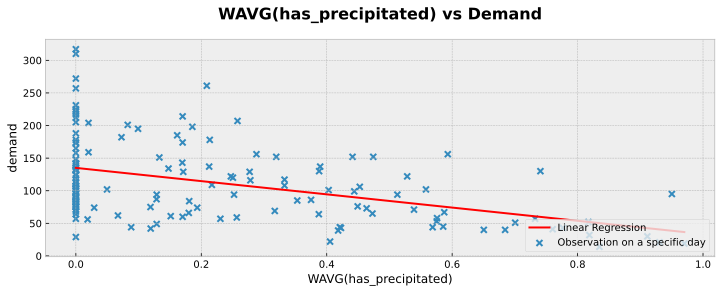

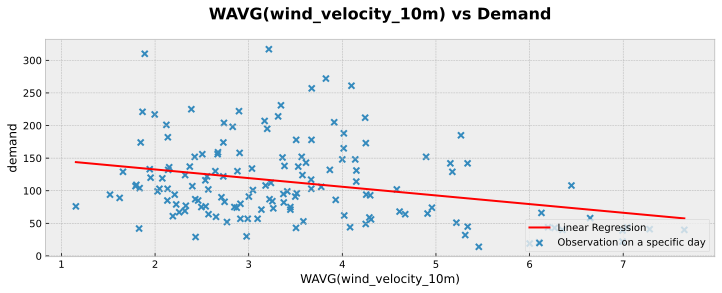

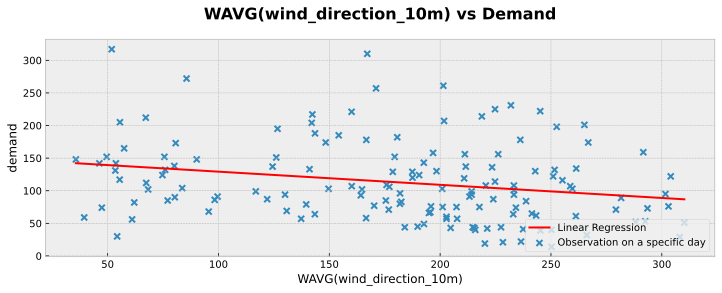

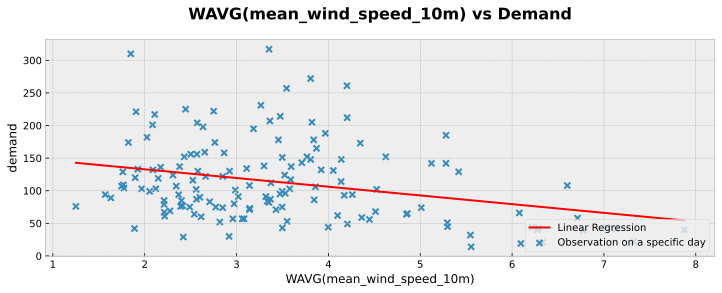

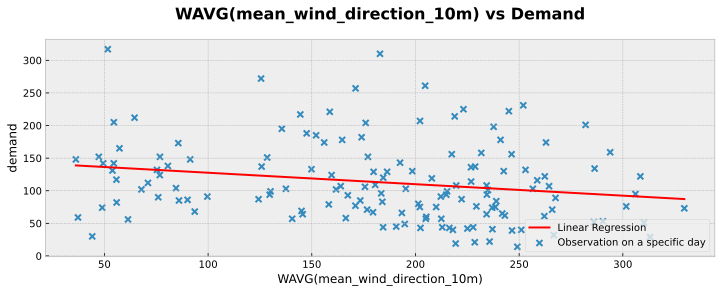

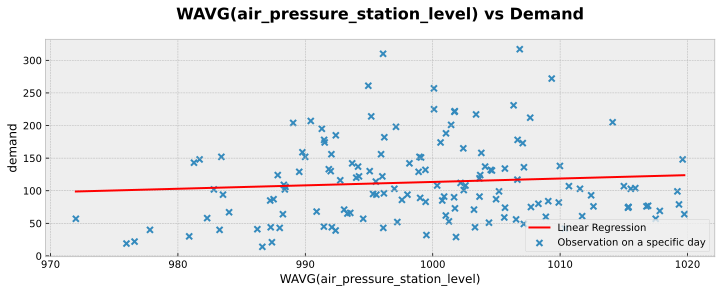

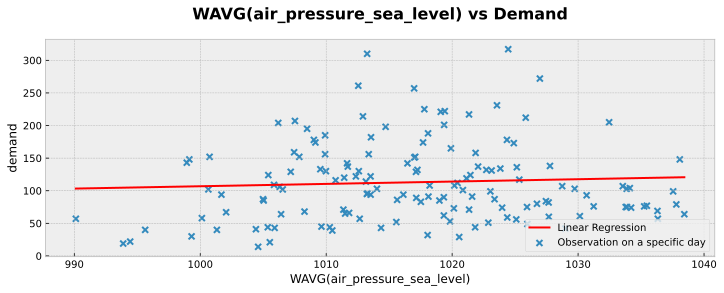

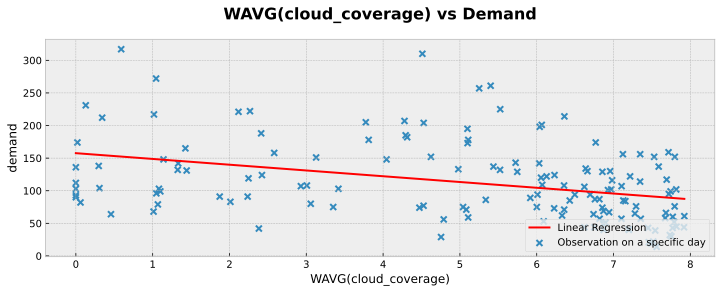

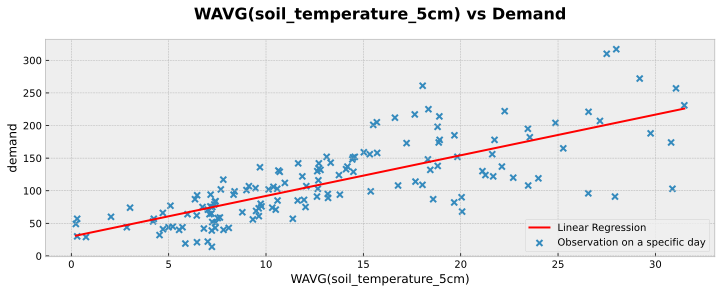

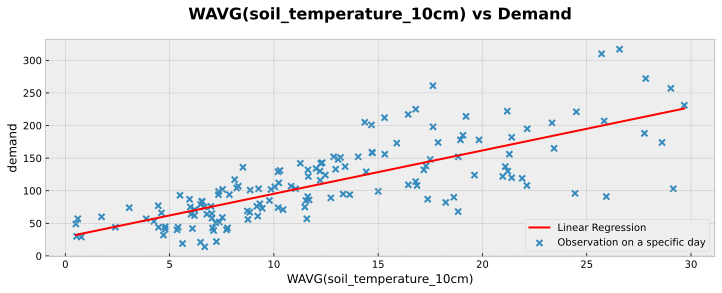

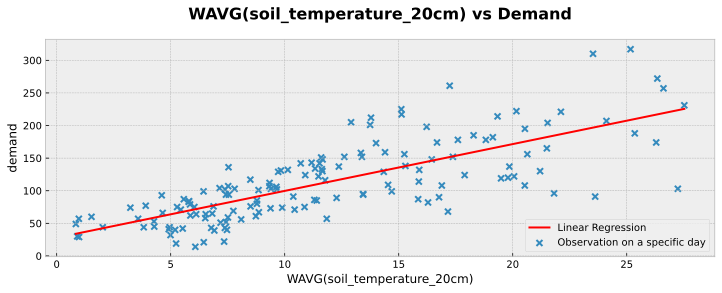

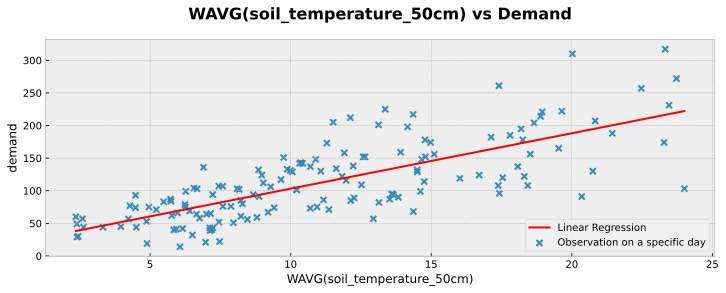

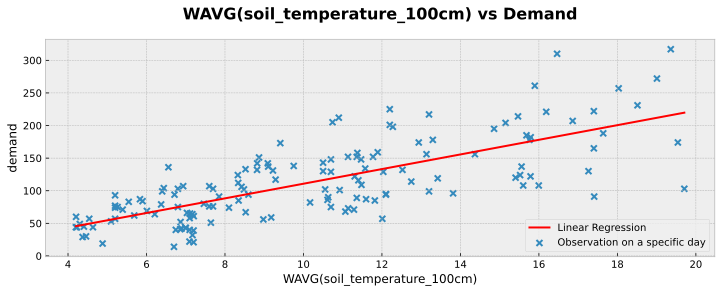

In [13]:
plot_all_features("Essen")

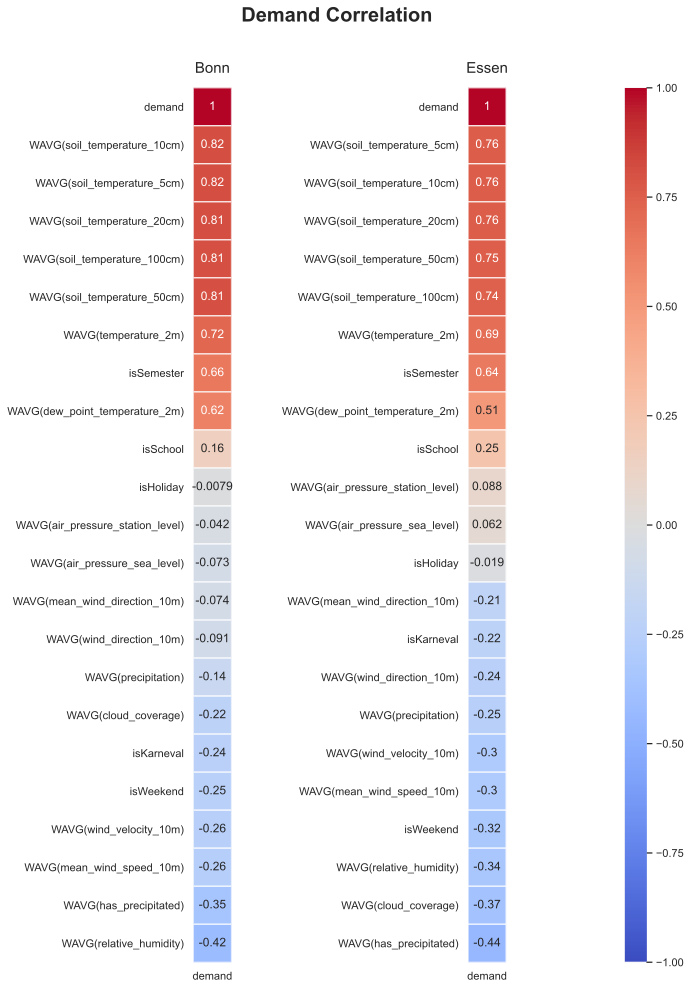

In [14]:
sns.set_theme()
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(10,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)

g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_title("Essen", fontsize=15, pad=15)

f.tight_layout()
f.suptitle('Demand Correlation', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('Demand Correlation.png', bbox_inches='tight')
plt.show()

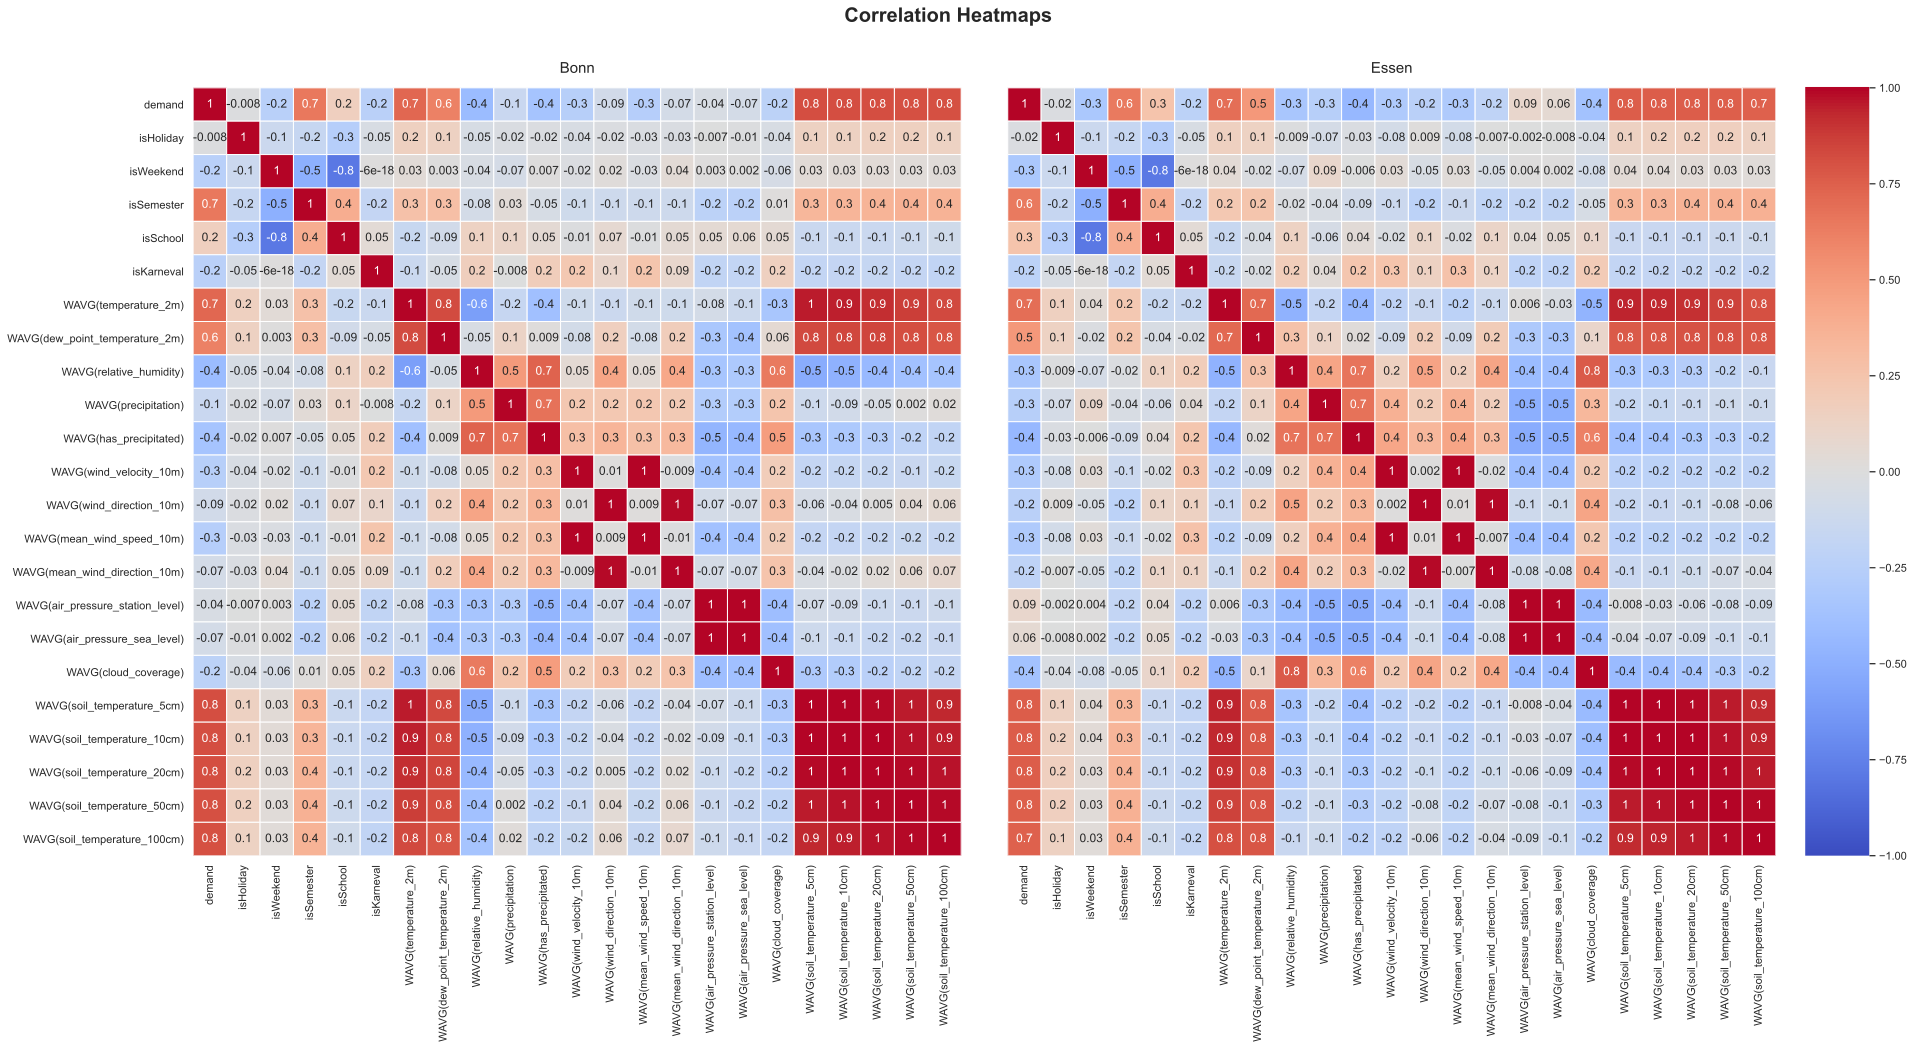

In [15]:
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(27,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_title("Essen", fontsize=15, pad=15)

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

f.tight_layout()
f.suptitle('Correlation Heatmaps', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('heatmaps.pdf', bbox_inches='tight')
plt.show()

## Picking features 

In [16]:
all_features = [ 
    'isHoliday',
    'isWeekend', 
    'isSemester', 
    'isSchool',
    'isKarneval', 
    'WAVG(temperature_2m)', 
    'WAVG(dew_point_temperature_2m)',
    'WAVG(relative_humidity)', 
    'WAVG(precipitation)',
    'WAVG(has_precipitated)', 
    'WAVG(wind_velocity_10m)',
    'WAVG(wind_direction_10m)', 
    'WAVG(mean_wind_speed_10m)',
    'WAVG(mean_wind_direction_10m)',
    'WAVG(air_pressure_station_level)',
    'WAVG(air_pressure_sea_level)', 
    'WAVG(cloud_coverage)',
    'WAVG(soil_temperature_5cm)', 
    'WAVG(soil_temperature_10cm)',
    'WAVG(soil_temperature_20cm)', 
    'WAVG(soil_temperature_50cm)',
    'WAVG(soil_temperature_100cm)'
]

features = [
    'isWeekend', 
    'isSemester',
    'isSchool',
    'isKarneval', 
    'WAVG(temperature_2m)',
    'WAVG(has_precipitated)',
    'WAVG(mean_wind_speed_10m)',
    'WAVG(soil_temperature_5cm)'
]

In [17]:
X_bonn, y_bonn = df_bonn[features], df_bonn["demand"]
# Create training, validation and test data:
X_bonn_train, X_bonn_test, y_bonn_train, y_bonn_test = train_test_split(X_bonn, y_bonn, test_size=0.2, random_state=42)
X_bonn_train, X_bonn_val, y_bonn_train, y_bonn_val = train_test_split(X_bonn_train, y_bonn_train, test_size=0.25, random_state=42)

In [18]:
X_essen, y_essen = df_essen[features], df_essen["demand"]
# Create training, validation and test data:
X_essen_train, X_essen_test, y_essen_train, y_essen_test = train_test_split(X_essen, y_essen, test_size=0.2, random_state=42)
X_essen_train, X_essen_val, y_essen_train, y_essen_val = train_test_split(X_essen_train, y_essen_train, test_size=0.25, random_state=42)

In [19]:
X_bonn_train

isWeekend  isSemester  isSchool  isKarneval  WAVG(temperature_2m)  \
2019-02-21        0.0         0.0       1.0         0.0              9.749063   
2019-06-20        0.0         0.0       0.0         0.0             18.636263   
2019-05-27        0.0         1.0       1.0         0.0             15.245638   
2019-03-20        0.0         0.0       1.0         0.0              9.197641   
2019-05-24        0.0         1.0       1.0         0.0             19.177253   
...               ...         ...       ...         ...                   ...   
2019-05-31        0.0         1.0       1.0         0.0             19.881334   
2019-04-01        0.0         1.0       1.0         0.0             11.593711   
2019-05-03        0.0         1.0       1.0         0.0              9.206259   
2019-04-25        0.0         1.0       0.0         0.0             17.673517   
2019-03-28        0.0         0.0       1.0         0.0              9.382358   

            WAVG(has_precipitated)  WAVG(mean_wind_speed_10m)  \
2019-02-21                0.279906                   2.444299   
2019-06-20                0.432761                   1.958966   
2019-05-27                0.608908                   1.804018   
2019-03-20                0.000000                   2.097938   
2019-05-24                0.000000                   1.816661   
...                            ...                        ...   
2019-05-31                0.000000                   1.991544   
2019-04-01                0.000000                   2.635041   
2019-05-03                0.470452                   2.883112   
2019-04-25                0.000000                   4.527365   
2019-03-28                0.000000                   1.645252   

            WAVG(soil_temperature_5cm)  
2019-02-21                    8.004476  
2019-06-20                   22.619413  
2019-05-27                   18.107969  
2019-03-20                    9.431225  
2019-05-24                   20.473893  
...                                ...  
2019-05-31                   22.285562  
2019-04-01                   12.887574  
2019-05-03                   13.049251  
2019-04-25                   17.812381  
2019-03-28                   10.230695  

[87 rows x 8 columns]

---

## Training a Regression Model

In [20]:
r2_bonn = []
r2_essen = []

# function for plotting
def plot_scikit_output(x, y, model, feature, name, city, label=None):
    min_x, max_x = x.min(), x.max()
    x_space = np.linspace(min_x, max_x, 400)
    color = 'C3' if city=="Bonn" else 'C0'
    # plotting routine
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, marker="x", color='C2')
    plt.plot(x_space, model.predict(x_space.reshape(-1, 1)), color=color, label=label)
    plt.xlabel(feature)
    plt.ylabel("Demand")
    plt.legend()
    plt.title(name, fontsize=16, fontweight="bold", pad=20)
    plt.tight_layout()

### Linear Regression

#### Bonn

In [21]:
lr_bonn = LinearRegression(normalize=True)
lr_bonn.fit(X_bonn_train, y_bonn_train)
# Training R2 score (1.0 is best):
lr_bonn.score(X_bonn_train, y_bonn_train)

0.8822621959459777

In [22]:
# Validation R2 score (1.0 is best):
y_bonn_pred_lr = lr_bonn.predict(X_bonn_val)
lr_bonn.score(X_bonn_val, y_bonn_val)

0.7405125052407306

In [23]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_lr))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_lr))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_lr))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_lr))

MSE: 193092.821877971
MAE: 360.2090659009216
R2:  0.7405125052407306


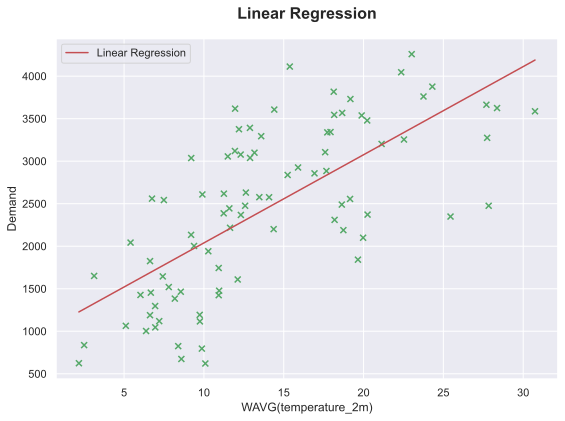

In [24]:
lr_feature = "WAVG(temperature_2m)"
lr_bonn = LinearRegression().fit(X_bonn_train[lr_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[lr_feature], y_bonn_train, lr_bonn, lr_feature, "Linear Regression", "Bonn", "Linear Regression")

#### Essen

In [25]:
lr_essen = LinearRegression(normalize=True)
lr_essen.fit(X_essen_train, y_essen_train)
# Training R2 score (1.0 is best):
lr_essen.score(X_essen_train, y_essen_train)

0.799409547090023

In [26]:
# Validation R2 score (1.0 is best):
y_essen_pred_lr = lr_essen.predict(X_essen_val)
lr_essen.score(X_essen_val, y_essen_val)

0.7035422879790074

In [27]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_lr))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_lr))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_lr))
print("R2: ", r2_score(y_essen_val, y_essen_pred_lr))

MSE: 562.2682845681703
MAE: 18.909494396911875
R2:  0.7035422879790074


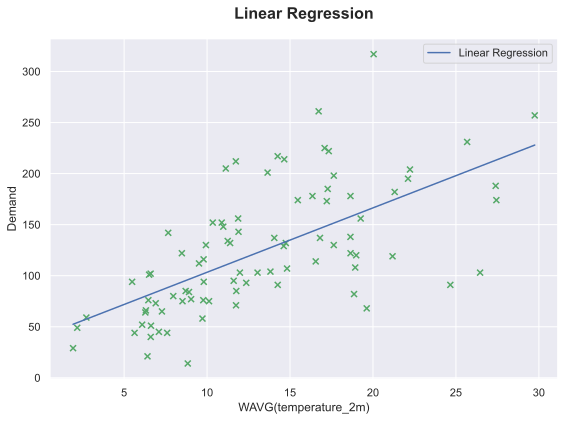

In [28]:
lr_feature = "WAVG(temperature_2m)"
lr_essen = LinearRegression().fit(X_essen_train[lr_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[lr_feature], y_essen_train, lr_essen, lr_feature, "Linear Regression", "Essen", "Linear Regression")

---

### Lasso Regression

#### Bonn

Text(0.5, 1.0, 'Lasso Regression Error Validation')

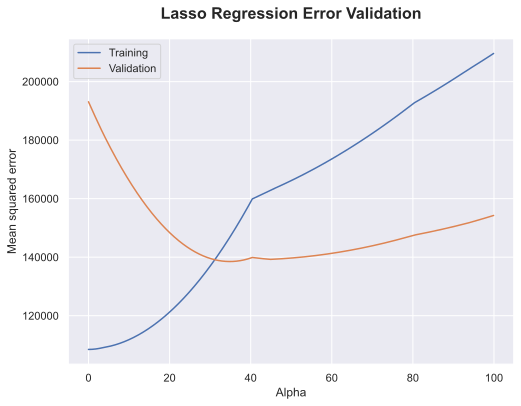

In [29]:
# Search the best lasso alpha
err_train_lasso = []
err_val_lasso = []

for alpha in np.arange(0, 100, 0.1):
    # Fit model
    lasso_reg_bonn = Lasso(alpha=alpha)
    lasso_model_bonn = lasso_reg_bonn.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_lasso.append(mean_squared_error(y_bonn_train, lasso_model_bonn.predict(X_bonn_train)))
    err_val_lasso.append(mean_squared_error(y_bonn_val, lasso_model_bonn.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100, 0.1), err_train_lasso, np.arange(0, 100, 0.1), err_val_lasso)
plt.legend(["Training", "Validation"])
plt.xlabel("Alpha")
plt.ylabel("Mean squared error")
plt.title("Lasso Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [30]:
print("Best validation value for", np.argmin(err_val_lasso)/10, "alpha")

Best validation value for 34.9 alpha


In [31]:
lasso_reg_bonn = Lasso(alpha=np.argmin(err_val_lasso)/10)
lasso_model_bonn = lasso_reg_bonn.fit(X_bonn_train, y_bonn_train)

y_bonn_pred_lasso = lasso_model_bonn.predict(X_bonn_val)

In [32]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_lasso))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_lasso))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_lasso))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_lasso))

MSE: 138516.21679415592
MAE: 309.7523671599119
R2:  0.8138551929073655


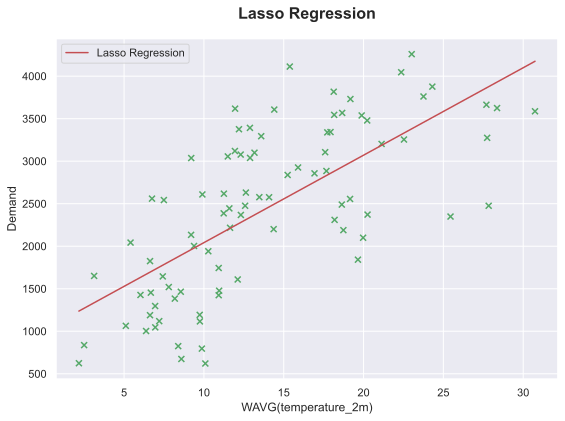

In [33]:
lasso_feature = "WAVG(temperature_2m)"
lasso_bonn = Lasso(alpha=np.argmin(err_val_lasso)/10).fit(X_bonn_train[lasso_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[lasso_feature], y_bonn_train, lasso_bonn, lasso_feature, "Lasso Regression", "Bonn", "Lasso Regression")

#### Essen

Text(0.5, 1.0, 'Lasso Regression Error Validation')

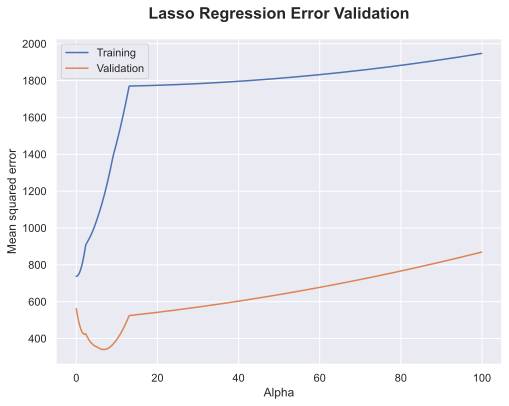

In [34]:
# Search the best lasso alpha
err_train_lasso = []
err_val_lasso = []

for alpha in np.arange(0, 100, 0.1):
    # Fit model
    lasso_reg_essen = Lasso(alpha=alpha)
    lasso_model_essen = lasso_reg_essen.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_lasso.append(mean_squared_error(y_essen_train, lasso_model_essen.predict(X_essen_train)))
    err_val_lasso.append(mean_squared_error(y_essen_val, lasso_model_essen.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100, 0.1), err_train_lasso, np.arange(0, 100, 0.1), err_val_lasso)
plt.legend(["Training", "Validation"])
plt.xlabel("Alpha")
plt.ylabel("Mean squared error")
plt.title("Lasso Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [35]:
print("Best validation value for", np.argmin(err_val_lasso)/10, "alpha")

Best validation value for 6.7 alpha


In [36]:
lasso_reg_essen = Lasso(alpha=np.argmin(err_val_lasso)/10)
lasso_model_essen = lasso_reg_essen.fit(X_essen_train, y_essen_train)

y_essen_pred_lasso = lasso_model_essen.predict(X_essen_val)

In [37]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_lasso))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_lasso))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_lasso))
print("R2: ", r2_score(y_essen_val, y_essen_pred_lasso))

MSE: 340.4646246385975
MAE: 15.375492016359482
R2:  0.8204889615604714


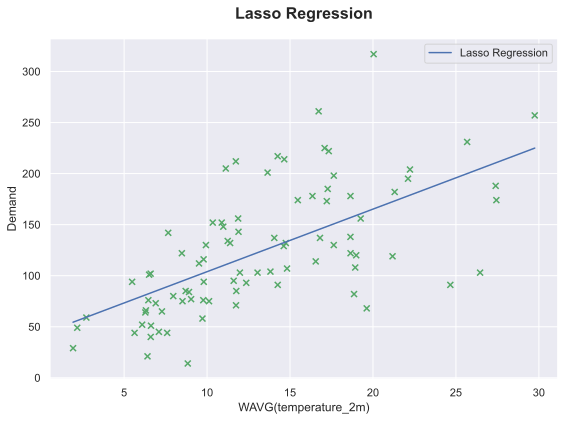

In [38]:
lasso_feature = "WAVG(temperature_2m)"
lasso_essen = Lasso(alpha=np.argmin(err_val_lasso)/10).fit(X_essen_train[lasso_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[lasso_feature], y_essen_train, lasso_essen, lasso_feature, "Lasso Regression", "Essen", "Lasso Regression")

---

### Ridge Regression

#### Bonn

Text(0.5, 1.0, 'Ridge Regression Error Validation')

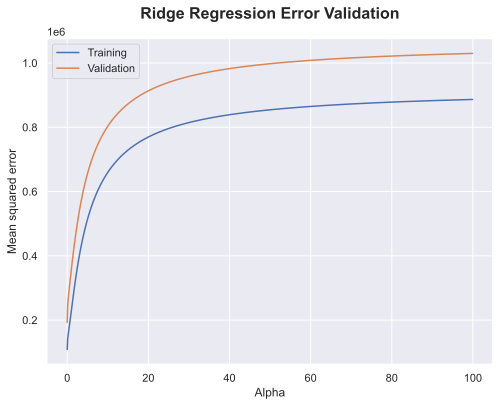

In [39]:
# Search the best lasso alpha
err_train_ridge = []
err_val_ridge = []

for alpha in np.arange(0, 100, 0.1):
    # Fit model
    ridge_reg_bonn = Ridge(alpha=alpha, normalize=True, solver='lsqr')
    ridge_model_bonn = ridge_reg_bonn.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_ridge.append(mean_squared_error(y_bonn_train, ridge_model_bonn.predict(X_bonn_train)))
    err_val_ridge.append(mean_squared_error(y_bonn_val, ridge_model_bonn.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100, 0.1), err_train_ridge, np.arange(0, 100, 0.1), err_val_ridge)
plt.legend(["Training", "Validation"])
plt.xlabel("Alpha")
plt.ylabel("Mean squared error")
plt.title("Ridge Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [40]:
print("Best validation value for", np.argmin(err_val_ridge)/10, "alpha")

Best validation value for 0.0 alpha


In [41]:
ridge_reg_bonn = Ridge(alpha=np.argmin(err_val_ridge)/10, normalize=True, solver='lsqr')
ridge_model_bonn = ridge_reg_bonn.fit(X_bonn_train, y_bonn_train)

y_bonn_pred_ridge = ridge_model_bonn.predict(X_bonn_val)

In [42]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_ridge))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_ridge))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_ridge))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_ridge))

MSE: 193092.8218780463
MAE: 360.20906590097337
R2:  0.7405125052406296


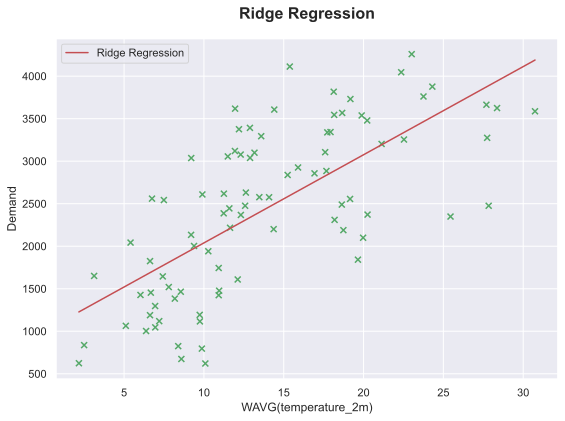

In [43]:
ridge_feature = "WAVG(temperature_2m)"
ridge_bonn = Ridge(alpha=np.argmin(err_val_ridge)/10, normalize=True, solver='lsqr').fit(X_bonn_train[ridge_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[ridge_feature], y_bonn_train, ridge_bonn, ridge_feature, "Ridge Regression", "Bonn", "Ridge Regression")

#### Essen

Text(0.5, 1.0, 'Ridge Regression Error Validation')

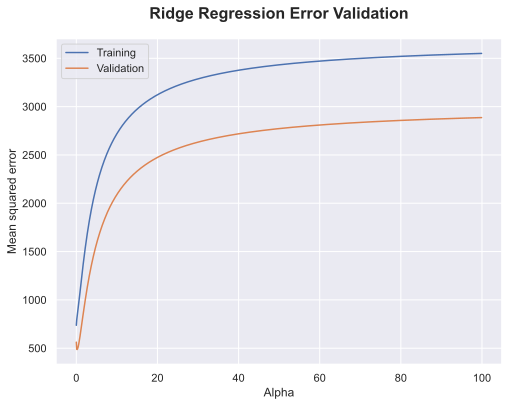

In [44]:
# Search the best lasso alpha
err_train_ridge = []
err_val_ridge = []

for alpha in np.arange(0, 100, 0.1):
    # Fit model
    ridge_reg_essen = Ridge(alpha=alpha, normalize=True, solver='lsqr')
    ridge_model_essen = ridge_reg_essen.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_ridge.append(mean_squared_error(y_essen_train, ridge_model_essen.predict(X_essen_train)))
    err_val_ridge.append(mean_squared_error(y_essen_val, ridge_model_essen.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100, 0.1), err_train_ridge, np.arange(0, 100, 0.1), err_val_ridge)
plt.legend(["Training", "Validation"])
plt.xlabel("Alpha")
plt.ylabel("Mean squared error")
plt.title("Ridge Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [45]:
print("Best validation value for", np.argmin(err_val_ridge)/10, "alpha")

Best validation value for 0.2 alpha


In [46]:
ridge_reg_essen = Ridge(alpha=np.argmin(err_val_ridge)/10, normalize=True, solver='lsqr')
ridge_model_essen = ridge_reg_essen.fit(X_essen_train, y_essen_train)

y_essen_pred_ridge = ridge_model_essen.predict(X_essen_val)

In [47]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_ridge))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_ridge))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_ridge))
print("R2: ", r2_score(y_essen_val, y_essen_pred_ridge))

MSE: 486.66227510202265
MAE: 17.666119843215608
R2:  0.743405792993497


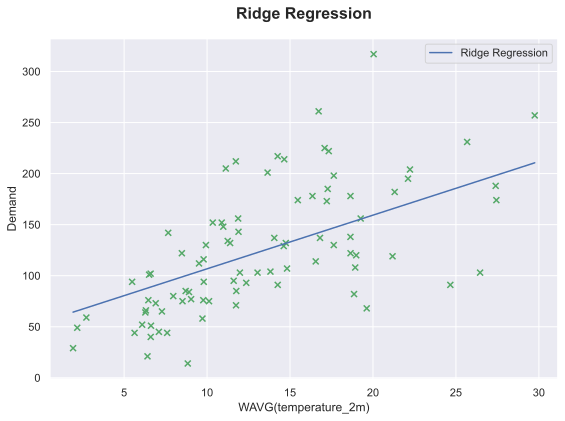

In [48]:
ridge_feature = "WAVG(temperature_2m)"
ridge_essen = Ridge(alpha=np.argmin(err_val_ridge)/10, normalize=True, solver='lsqr').fit(X_essen_train[ridge_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[ridge_feature], y_essen_train, ridge_essen, ridge_feature, "Ridge Regression", "Essen", "Ridge Regression")

---

### Polynomial Regression

In [49]:
# function for plotting polynomial
def plot_scikit_poly_output(x, y, model, poly, feature, name, city, label=None):
    min_x, max_x = x.min(), x.max()
    x_space = np.linspace(min_x, max_x, 400)
    #x_space = np.arange(min_x, max_x,1)[:, np.newaxis]
    color = 'C3' if city=="Bonn" else 'C0'
    # plotting routine
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, marker="x", color='C2')
    plt.plot(x_space, model.predict(poly.fit_transform(x_space.reshape(-1, 1))), color=color, label=label)
    plt.xlabel(feature)
    plt.ylabel("Demand")
    plt.legend()
    plt.title(name, fontsize=16, fontweight="bold", pad=20)

#### Bonn

CPU times: user 5min 58s, sys: 1.07 s, total: 5min 59s
Wall time: 1min 31s


Text(0.5, 1.0, 'Polinomial Regression Error Validation')

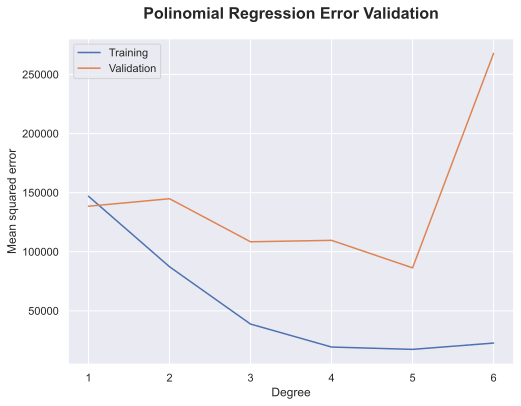

In [50]:
%%time
# Search the best degree and alpha
err_train_poly = []
err_val_poly_bonn = []
alphas_poly_bonn = []

for degree in range(1, 7):
    # Fit model
    poly = PolynomialFeatures(degree=degree)
    err_val = []
    X_poly_train = poly.fit_transform(X_bonn_train)
    X_poly_val = poly.fit_transform(X_bonn_val)
    for alpha in np.arange(0, 50, 0.1):
        poly_reg_bonn = Lasso(alpha=alpha)
        poly_model_bonn = poly_reg_bonn.fit(X_poly_train, y_bonn_train)
        err_val.append(mean_squared_error(y_bonn_val, poly_model_bonn.predict(X_poly_val)))
    
    alphas_poly_bonn.append(np.argmin(err_val)/10)
    poly_reg_bonn = Lasso(alpha=np.argmin(err_val)/10)
    poly_model_bonn = poly_reg_bonn.fit(X_poly_train, y_bonn_train)
    
    # Compute errors
    err_train_poly.append(mean_squared_error(y_bonn_train, poly_model_bonn.predict(X_poly_train)))
    err_val_poly_bonn.append(mean_squared_error(y_bonn_val, poly_model_bonn.predict(X_poly_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 7), err_train_poly, range(1, 7), err_val_poly_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Degree")
plt.ylabel("Mean squared error")
plt.title("Polinomial Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [51]:
alphas_poly_bonn

[34.9, 49.9, 1.1, 0.4, 2.7, 49.9]

In [52]:
print("Best validation value for degree", np.argmin(err_val_poly_bonn)+1, "and alpha", alphas_poly_bonn[np.argmin(err_val_poly_bonn)])

Best validation value for degree 5 and alpha 2.7


In [53]:
# Fit model (for the optimal degree and alpha)
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_bonn)+1)
X_poly_train = poly.fit_transform(X_bonn_train)
X_poly_val = poly.transform(X_bonn_val)
poly_reg_bonn = Lasso(alpha=alphas_poly_bonn[np.argmin(err_val_poly_bonn)])
poly_model_bonn = poly_reg_bonn.fit(X_poly_train, y_bonn_train)

# Predict
y_bonn_pred_poly = poly_model_bonn.predict(X_poly_val)

In [54]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_poly))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_poly))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_poly))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_poly))

MSE: 86344.88067104101
MAE: 234.44489376912472
R2:  0.8839655635424084


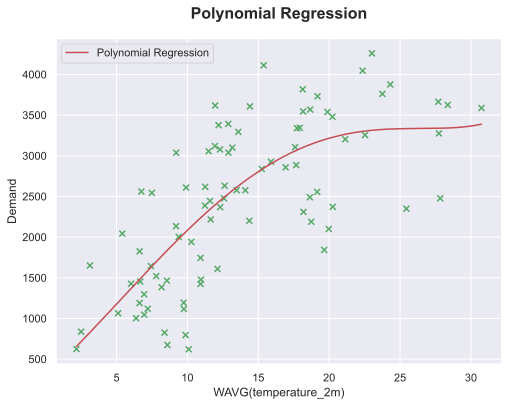

In [55]:
poly_feature = "WAVG(temperature_2m)"
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_bonn)+1)
X_poly_train = poly.fit_transform(X_bonn_train[poly_feature].values.reshape(-1,1))

poly_bonn = Lasso(alpha=alphas_poly_bonn[np.argmin(err_val_poly_bonn)]).fit(X_poly_train, y_bonn_train)
plot_scikit_poly_output(X_bonn_train[poly_feature], y_bonn_train, poly_bonn, poly, poly_feature, "Polynomial Regression", "Bonn", "Polynomial Regression")

#### Essen

CPU times: user 5min 12s, sys: 896 ms, total: 5min 12s
Wall time: 1min 19s


Text(0.5, 1.0, 'Polinomial Regression Error Validation')

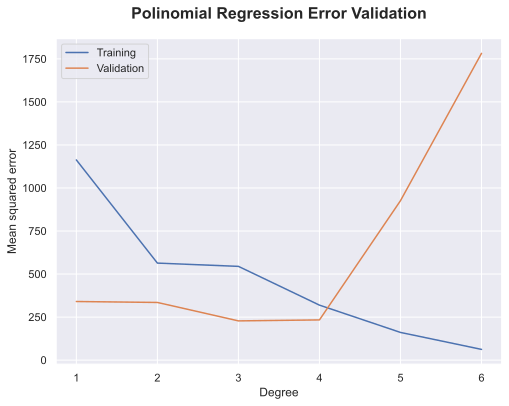

In [56]:
%%time
# Search the best degree and alpha
err_train_poly = []
err_val_poly_essen = []
alphas_poly_essen = []

for degree in range(1, 7):
    # Fit model
    poly = PolynomialFeatures(degree=degree)
    err_val = []
    X_poly_train = poly.fit_transform(X_essen_train)
    X_poly_val = poly.transform(X_essen_val)
    for alpha in np.arange(0, 50, 0.1):
        poly_reg_essen = Lasso(alpha=alpha)
        poly_model_essen = poly_reg_essen.fit(X_poly_train, y_essen_train)
        err_val.append(mean_squared_error(y_essen_val, poly_model_essen.predict(X_poly_val)))
    
    alphas_poly_essen.append(np.argmin(err_val)/10)
    poly_reg_essen = Lasso(alpha=np.argmin(err_val)/10)
    poly_model_essen = poly_reg_essen.fit(X_poly_train, y_essen_train)
    
    # Compute errors
    err_train_poly.append(mean_squared_error(y_essen_train, poly_model_essen.predict(X_poly_train)))
    err_val_poly_essen.append(mean_squared_error(y_essen_val, poly_model_essen.predict(X_poly_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 7), err_train_poly, range(1, 7), err_val_poly_essen)
plt.legend(["Training", "Validation"])
plt.xlabel("Degree")
plt.ylabel("Mean squared error")
plt.title("Polinomial Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [57]:
alphas_poly_essen

[6.7, 3.7, 22.7, 49.9, 49.9, 22.5]

In [58]:
print("Best validation value for degree", np.argmin(err_val_poly_essen)+1, "and alpha", alphas_poly_essen[np.argmin(err_val_poly_essen)])

Best validation value for degree 3 and alpha 22.7


In [59]:
# Fit model (for the optimal degree and alpha)
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_essen)+1)
X_poly_train = poly.fit_transform(X_essen_train)
X_poly_val = poly.transform(X_essen_val)
poly_reg_essen = Lasso(alpha=alphas_poly_essen[np.argmin(err_val_poly_essen)])
poly_model_essen = poly_reg_essen.fit(X_poly_train, y_essen_train)

# Predict
y_essen_pred_poly = poly_model_essen.predict(X_poly_val)

In [60]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_poly))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_poly))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_poly))
print("R2: ", r2_score(y_essen_val, y_essen_pred_poly))

MSE: 227.82889661123164
MAE: 12.273183078500779
R2:  0.8798765015289705


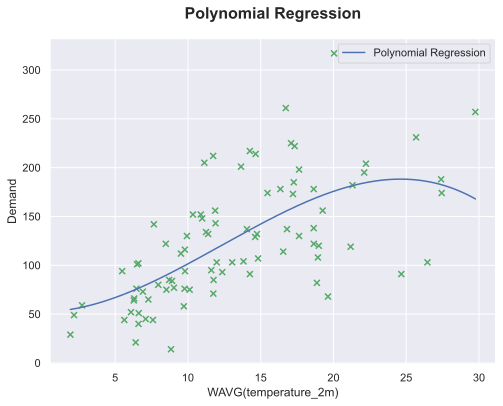

In [61]:
poly_feature = "WAVG(temperature_2m)"
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_essen)+1)
X_poly_train = poly.fit_transform(X_essen_train[poly_feature].values.reshape(-1,1))

poly_essen = Lasso(alpha=alphas_poly_essen[np.argmin(err_val_poly_essen)]).fit(X_poly_train, y_essen_train)
plot_scikit_poly_output(X_essen_train[poly_feature], y_essen_train, poly_essen, poly, poly_feature, "Polynomial Regression", "Essen", "Polynomial Regression")

---

### Tree-Based Regression

#### Bonn   
Which tree depth parameter $\mathrm{depth}$ is optimal?

Text(0.5, 1.0, 'Tree-Based Regression Error Validation')

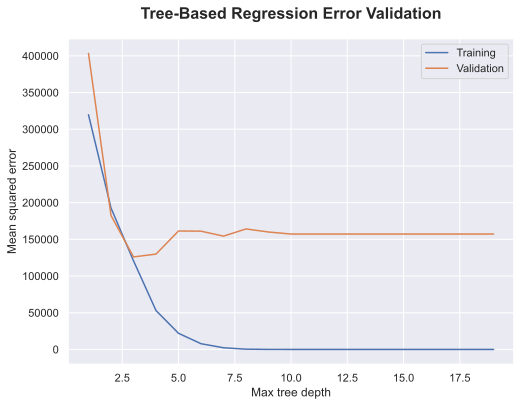

In [62]:
# Search the best tree depth
err_train_tree = []
err_val_tree = []

for depth in range(1, 20):
    # Fit model
    tree_reg_bonn = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=42)
    tree_model_bonn = tree_reg_bonn.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_tree.append(mean_squared_error(y_bonn_train, tree_model_bonn.predict(X_bonn_train)))
    err_val_tree.append(mean_squared_error(y_bonn_val, tree_model_bonn.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_tree, range(1, 20), err_val_tree)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Tree-Based Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [63]:
print("Best validation value for", np.argmin(err_val_tree)+1, "max depth")

Best validation value for 3 max depth


Train model with the optimal $\mathrm{depth}$.

In [64]:
# Fit model (for the optimal tree depth)
tree_reg_bonn = DecisionTreeRegressor(max_depth=np.argmin(err_val_tree)+1, criterion="mse", random_state=42)
tree_model_bonn = tree_reg_bonn.fit(X_bonn_train, y_bonn_train)

# Predict
y_bonn_pred_tree = tree_model_bonn.predict(X_bonn_val)

In [65]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_tree))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_tree))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_tree))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_tree))

MSE: 126076.42621284927
MAE: 300.0985558069381
R2:  0.8305723865444921


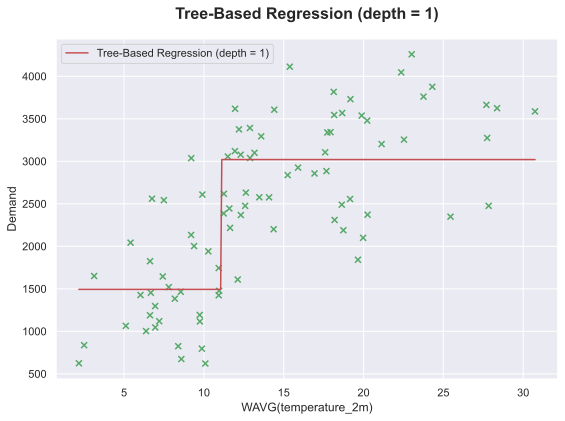

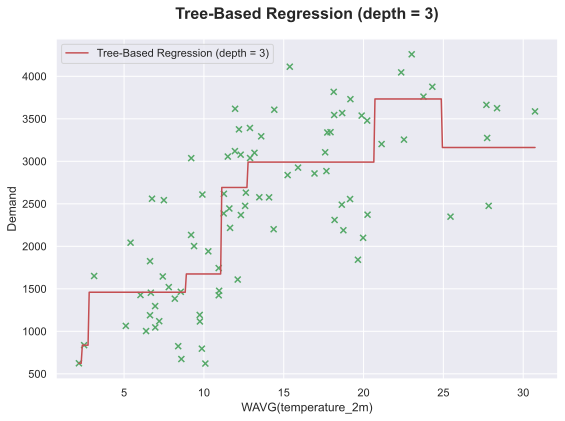

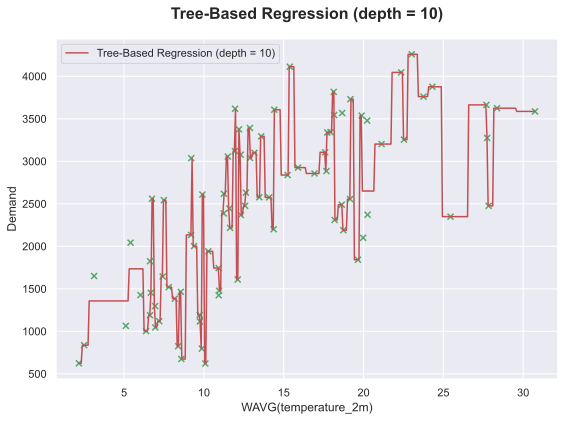

In [66]:
tree_feature = "WAVG(temperature_2m)"
for depth in (1, np.argmin(err_val_tree)+1, 10):
    tree_reg_bonn = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=42)
    tree_model_bonn = tree_reg_bonn.fit(X_bonn_train[tree_feature].values.reshape(-1, 1), y_bonn_train)
    plot_scikit_output(X_bonn_train[tree_feature], 
                       y_bonn_train, 
                       tree_model_bonn, 
                       tree_feature, 
                       f"Tree-Based Regression (depth = {depth})", 
                       "Bonn", 
                       f"Tree-Based Regression (depth = {depth})")

In [67]:
def plot_regression_tree_sklearn(tree_depth, city):
    
    if city == "Bonn":
        X = X_bonn_train
        y = y_bonn_train
    else:
        X = X_essen_train
        y = y_essen_train

    # Fit regression model
    model = DecisionTreeRegressor(max_depth=tree_depth, criterion="mse", random_state=42)
    model.fit(X[tree_feature].values.reshape(-1, 1), y) 
    
    dot_data = export_graphviz(model, feature_names=["WAVG(temperature_2m)"], filled=True, rounded=True)  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

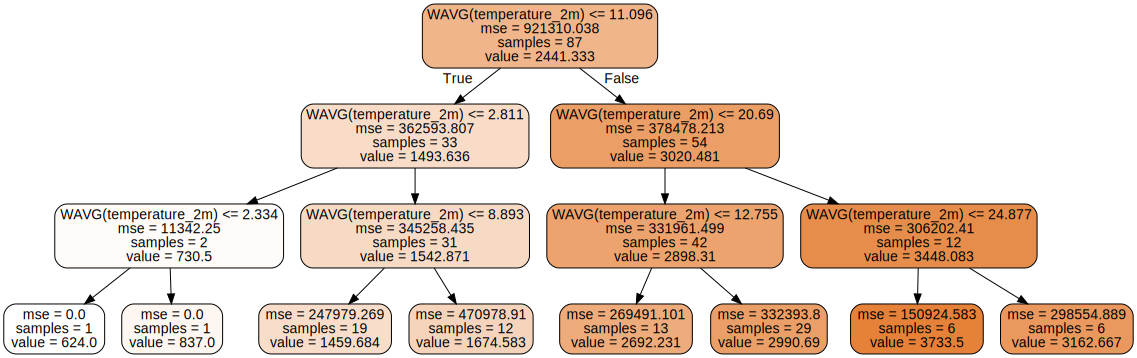

In [68]:
plot_regression_tree_sklearn(np.argmin(err_val_tree)+1, city="Bonn")

#### Essen   
Which tree depth parameter $\mathrm{depth}$ is optimal?

Text(0.5, 1.0, 'Tree-Based Regression Error Validation')

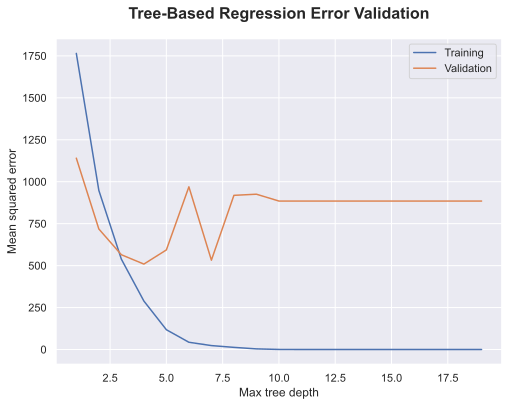

In [69]:
# Search the best tree depth
err_train_tree = []
err_val_tree = []

for depth in range(1, 20):
    # Fit model
    tree_reg_essen = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=42)
    tree_model_essen = tree_reg_essen.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_tree.append(mean_squared_error(y_essen_train, tree_model_essen.predict(X_essen_train)))
    err_val_tree.append(mean_squared_error(y_essen_val, tree_model_essen.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_tree, range(1, 20), err_val_tree)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Tree-Based Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [70]:
print("Best validation value for", np.argmin(err_val_tree)+1, "max depth")

Best validation value for 4 max depth


Train model with the optimal $\mathrm{depth}$.

In [71]:
# Fit model (for the optimal tree depth)
tree_reg_essen = DecisionTreeRegressor(max_depth=np.argmin(err_val_tree)+1, criterion="mse", random_state=42)
tree_model_essen = tree_reg_essen.fit(X_essen_train, y_essen_train)

# Predict
y_essen_pred_tree = tree_model_essen.predict(X_essen_val)

In [72]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_tree))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_tree))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_tree))
print("R2: ", r2_score(y_essen_val, y_essen_pred_tree))

MSE: 509.04089565276223
MAE: 18.080803412274
R2:  0.7316065952995465


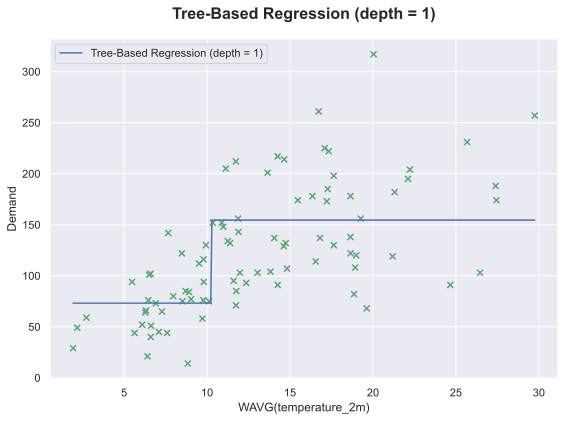

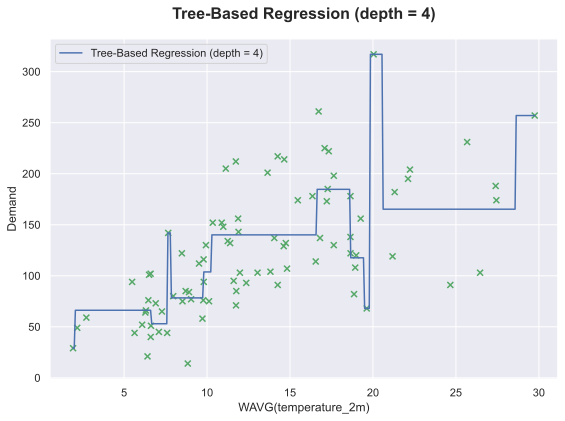

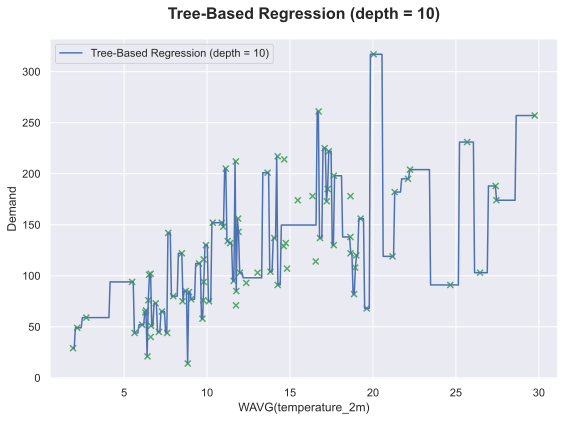

In [73]:
tree_feature = "WAVG(temperature_2m)"
for depth in (1, np.argmin(err_val_tree)+1, 10):
    tree_reg_essen = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=42)
    tree_model_essen = tree_reg_essen.fit(X_essen_train[tree_feature].values.reshape(-1, 1), y_essen_train)
    plot_scikit_output(X_essen_train[tree_feature], 
                       y_essen_train, 
                       tree_model_essen, 
                       tree_feature, 
                       f"Tree-Based Regression (depth = {depth})", 
                       "Essen", 
                       f"Tree-Based Regression (depth = {depth})")

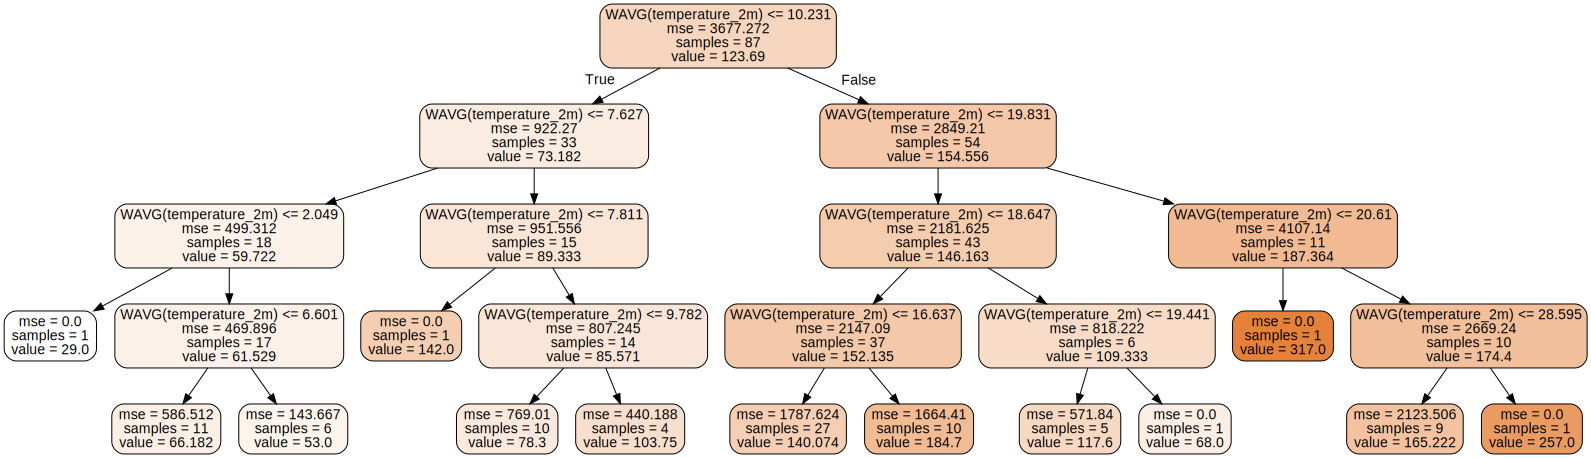

In [74]:
plot_regression_tree_sklearn(np.argmin(err_val_tree)+1, city="Essen")

---

### Boosting   
Let's test some boosting techniques.

#### AdaBoost

#### Bonn

In [75]:
ada_bonn = AdaBoostRegressor(random_state=42)
ada_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_ada = ada_bonn.predict(X_bonn_val)

In [76]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_ada))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_ada))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_ada))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_ada))

MSE: 137777.25577389292
MAE: 312.80752319954365
R2:  0.8148482445496166


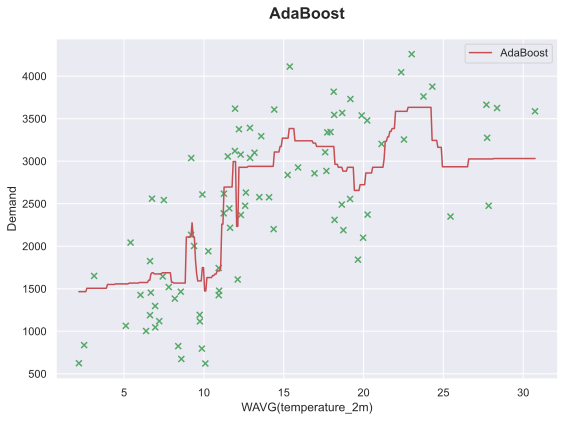

In [77]:
ada_feature = "WAVG(temperature_2m)"
ada_bonn = AdaBoostRegressor(random_state=42).fit(X_bonn_train[ada_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[ada_feature], 
                   y_bonn_train, 
                   ada_bonn, 
                   ada_feature, 
                   "AdaBoost", "Bonn", "AdaBoost")

#### Essen

In [78]:
ada_essen = AdaBoostRegressor(random_state=42)
ada_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_ada = ada_essen.predict(X_essen_val)

In [79]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_ada))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_ada))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_ada))
print("R2: ", r2_score(y_essen_val, y_essen_predict_ada))

MSE: 419.77849061482624
MAE: 16.853382260985203
R2:  0.7786704776014999


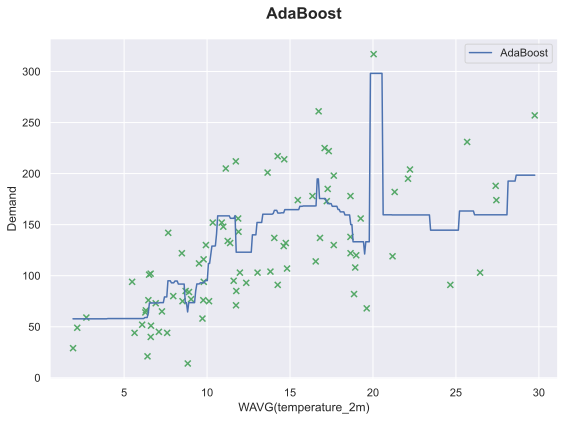

In [80]:
ada_feature = "WAVG(temperature_2m)"
ada_essen = AdaBoostRegressor(random_state=42).fit(X_essen_train[ada_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[ada_feature], 
                   y_essen_train, 
                   ada_essen, 
                   ada_feature, 
                   "AdaBoost", "Essen", "AdaBoost")

#### Gradient Tree Boosting

#### Bonn

In [81]:
gradient_bonn = GradientBoostingRegressor(random_state=42)
gradient_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_gradient = gradient_bonn.predict(X_bonn_val)

In [82]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_gradient))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_gradient))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_gradient))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_gradient))

MSE: 112015.18026055941
MAE: 259.198075617459
R2:  0.8494685705137723


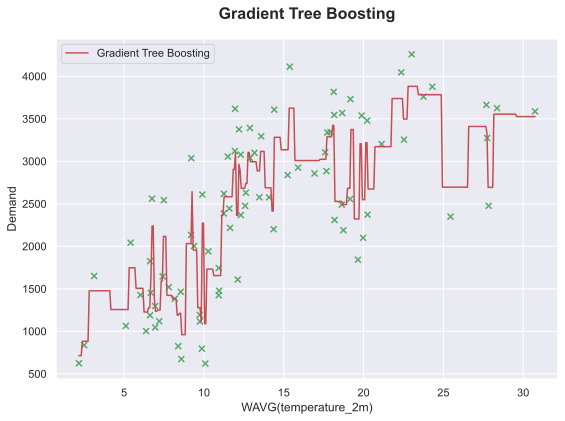

In [83]:
gradient_feature = "WAVG(temperature_2m)"
gradient_bonn = GradientBoostingRegressor(random_state=42).fit(X_bonn_train[gradient_feature].values.reshape(-1, 1), 
                                                              y_bonn_train)
plot_scikit_output(X_bonn_train[gradient_feature], 
                   y_bonn_train, 
                   gradient_bonn, 
                   gradient_feature, 
                   "Gradient Tree Boosting", "Bonn", "Gradient Tree Boosting")

#### Essen

In [84]:
gradient_essen = GradientBoostingRegressor(random_state=42)
gradient_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_gradient = gradient_essen.predict(X_essen_val)

In [85]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_gradient))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_gradient))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_gradient))
print("R2: ", r2_score(y_essen_val, y_essen_predict_gradient))

MSE: 576.7074824642406
MAE: 18.65530359338258
R2:  0.6959291757171717


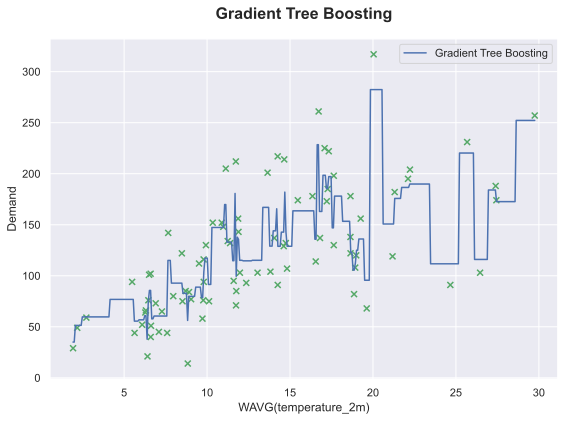

In [86]:
gradient_feature = "WAVG(temperature_2m)"
gradient_essen = GradientBoostingRegressor(random_state=42).fit(X_essen_train[gradient_feature].values.reshape(-1, 1), 
                                                               y_essen_train)
plot_scikit_output(X_essen_train[gradient_feature], 
                   y_essen_train, 
                   gradient_essen, 
                   gradient_feature, 
                   "Gradient Tree Boosting", "Essen", "Gradient Tree Boosting")

#### XGBoost

#### Bonn

Text(0.5, 1.0, 'XGBoost Error Validation')

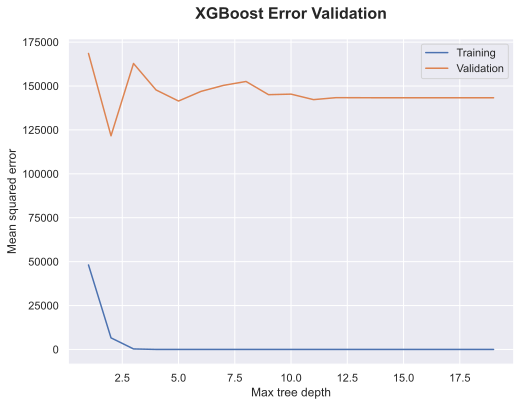

In [87]:
err_train_xg_bonn = []
err_val_xg_bonn = []

for depth in range(1, 20):
    # Fit model
    xg_regressor = xgb.XGBRegressor(max_depth = depth, random_state=42)
    xg_model = xg_regressor.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_xg_bonn.append(mean_squared_error(y_bonn_train, xg_model.predict(X_bonn_train)))
    err_val_xg_bonn.append(mean_squared_error(y_bonn_val, xg_model.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_xg_bonn, range(1, 20), err_val_xg_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("XGBoost Error Validation", fontsize=16, fontweight="bold", pad=20)

In [88]:
print("Best validation value for", np.argmin(err_val_xg_bonn)+1, "max depth")

Best validation value for 2 max depth


In [89]:
xg_reg_bonn = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_bonn)+1, random_state=42)
xg_reg_bonn.fit(X_bonn_train, y_bonn_train)

y_bonn_predict_xg = xg_reg_bonn.predict(X_bonn_val)

In [90]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_xg))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_xg))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_xg))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_xg))

MSE: 121651.83852878933
MAE: 289.90380859375
R2:  0.8365183619687107


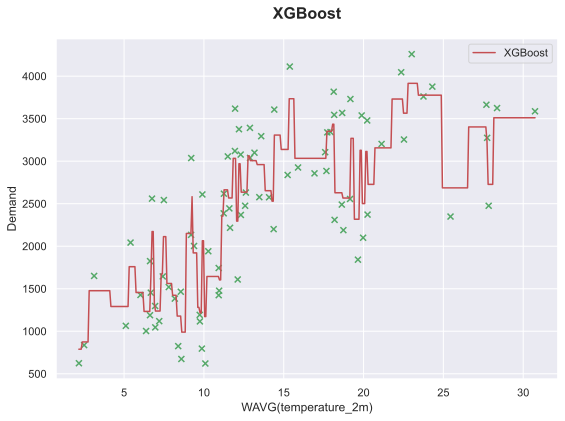

In [91]:
xg_feature = "WAVG(temperature_2m)"
xg_bonn = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_bonn)+1, random_state=42).fit(X_bonn_train[xg_feature].values.reshape(-1, 1), 
                                 y_bonn_train)
plot_scikit_output(X_bonn_train[xg_feature], 
                   y_bonn_train, 
                   xg_bonn, 
                   xg_feature, 
                   "XGBoost", "Bonn", "XGBoost")

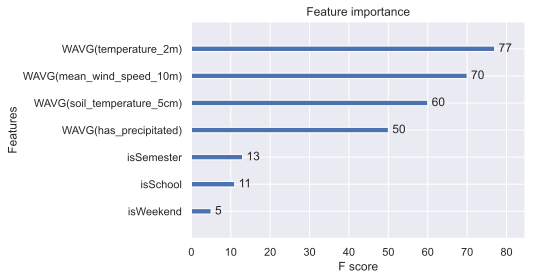

In [92]:
xgb.plot_importance(xg_reg_bonn)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

#### Essen

Text(0.5, 1.0, 'XGBoost Error Validation')

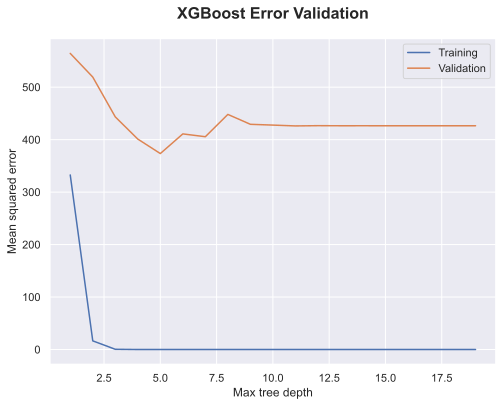

In [93]:
err_train_xg_essen = []
err_val_xg_essen = []

for depth in range(1, 20):
    # Fit model
    xg_regressor = xgb.XGBRegressor(max_depth = depth, random_state=42)
    xg_model = xg_regressor.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_xg_essen.append(mean_squared_error(y_essen_train, xg_model.predict(X_essen_train)))
    err_val_xg_essen.append(mean_squared_error(y_essen_val, xg_model.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_xg_essen, range(1, 20), err_val_xg_essen)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("XGBoost Error Validation", fontsize=16, fontweight="bold", pad=20)

In [94]:
print("Best validation value for", np.argmin(err_val_xg_essen)+1, "max depth")

Best validation value for 5 max depth


In [95]:
xg_reg_essen = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_essen)+1, random_state=42)
xg_reg_essen.fit(X_essen_train,y_essen_train)

y_essen_predict_xg = xg_reg_essen.predict(X_essen_val)

In [96]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_xg))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_xg))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_xg))
print("R2: ", r2_score(y_essen_val, y_essen_predict_xg))

MSE: 373.4779508841395
MAE: 14.754574139912924
R2:  0.8030825820196574


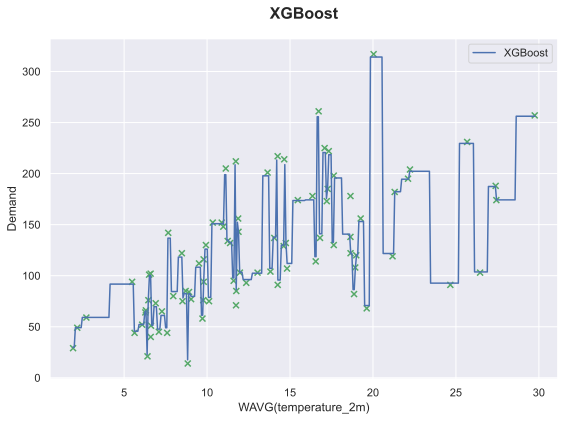

In [97]:
xg_feature = "WAVG(temperature_2m)"
xg_essen = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_essen)+1, random_state=42).fit(X_essen_train[xg_feature].values.reshape(-1, 1), 
                                                                           y_essen_train)
plot_scikit_output(X_essen_train[xg_feature], 
                   y_essen_train, 
                   xg_essen, 
                   xg_feature, 
                   "XGBoost", "Essen", "XGBoost")

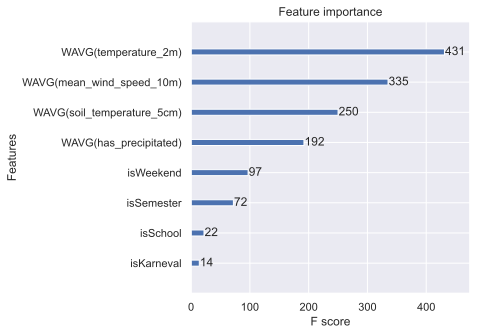

In [98]:
xgb.plot_importance(xg_reg_essen)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

---

### Bagging

#### Bonn

Text(0.5, 1.0, 'Bagging Error Validation')

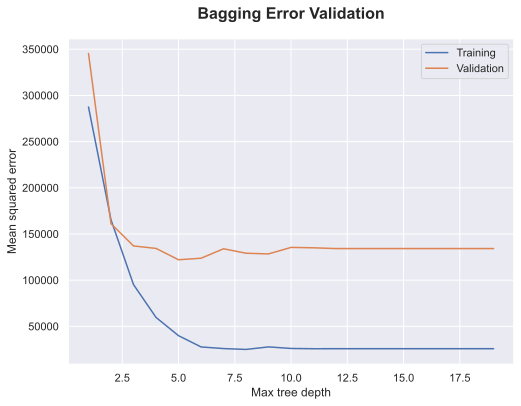

In [99]:
err_train_bagging_bonn = []
err_val_bagging_bonn = []

for depth in range(1, 20):
    # Fit model
    bagging_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=depth, 
                                                                              criterion="mse", 
                                                                              random_state=42), 
                                         random_state=42)
    bagging_model = bagging_regressor.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_bagging_bonn.append(mean_squared_error(y_bonn_train, bagging_model.predict(X_bonn_train)))
    err_val_bagging_bonn.append(mean_squared_error(y_bonn_val, bagging_model.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_bagging_bonn, range(1, 20), err_val_bagging_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Bagging Error Validation", fontsize=16, fontweight="bold", pad=20)

In [100]:
print("Best validation value for", np.argmin(err_val_bagging_bonn)+1, "max depth")

Best validation value for 5 max depth


In [101]:
bagging_bonn = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=np.argmin(err_val_bagging_bonn)+1,
                                                                     criterion="mse", 
                                                                     random_state=42), 
                                 random_state=42)
bagging_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_bagging = bagging_bonn.predict(X_bonn_val)

In [102]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_bagging))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_bagging))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_bagging))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_bagging))

MSE: 122081.40839019524
MAE: 276.90414141414135
R2:  0.8359410851643416


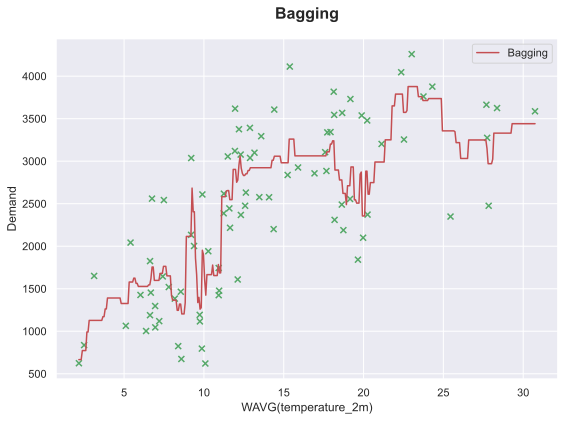

In [103]:
bagging_feature = "WAVG(temperature_2m)"
bagging_bonn = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=np.argmin(err_val_bagging_bonn)+1, 
                                                                     criterion="mse", 
                                                                     random_state=42), 
                                random_state=42).fit(X_bonn_train[bagging_feature].values.reshape(-1, 1), 
                                                    y_bonn_train)
plot_scikit_output(X_bonn_train[bagging_feature], 
                   y_bonn_train, 
                   bagging_bonn, 
                   bagging_feature, 
                   "Bagging", "Bonn", "Bagging")

#### Essen

Text(0.5, 1.0, 'Bagging Error Validation')

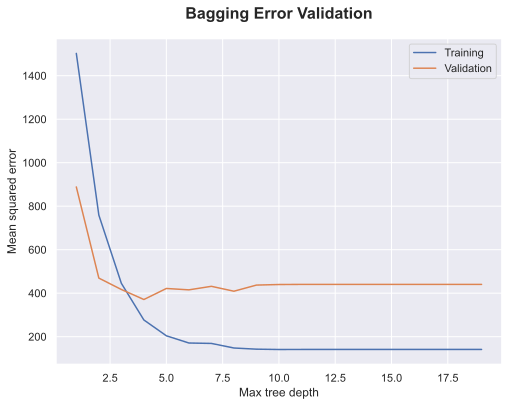

In [104]:
err_train_bagging_essen = []
err_val_bagging_essen = []

for depth in range(1, 20):
    # Fit model
    bagging_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=depth, 
                                                                              criterion="mse", 
                                                                              random_state=42), 
                                         random_state=42)
    bagging_model = bagging_regressor.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_bagging_essen.append(mean_squared_error(y_essen_train, bagging_model.predict(X_essen_train)))
    err_val_bagging_essen.append(mean_squared_error(y_essen_val, bagging_model.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_bagging_essen, range(1, 20), err_val_bagging_essen)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Bagging Error Validation", fontsize=16, fontweight="bold", pad=20)

In [105]:
print("Best validation value for", np.argmin(err_val_bagging_essen)+1, "max depth")

Best validation value for 4 max depth


In [106]:
bagging_essen =  BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=np.argmin(err_val_bagging_essen)+1,
                                                                       criterion="mse", 
                                                                       random_state=42), 
                              random_state=42)
bagging_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_bagging = bagging_essen.predict(X_essen_val)

In [107]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_bagging))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_bagging))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_bagging))
print("R2: ", r2_score(y_essen_val, y_essen_predict_bagging))

MSE: 370.9183748890015
MAE: 14.590328998347442
R2:  0.804432126470391


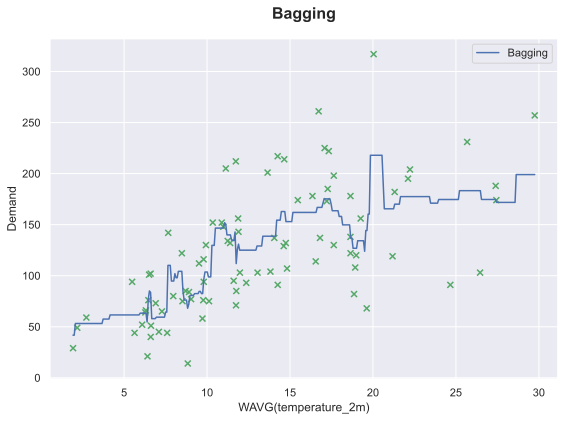

In [108]:
bagging_feature = "WAVG(temperature_2m)"
bagging_essen = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=np.argmin(err_val_bagging_essen)+1,
                                                                      criterion="mse", 
                                                                      random_state=42), 
                                random_state=42).fit(X_essen_train[bagging_feature].values.reshape(-1, 1), 
                                                    y_essen_train)
plot_scikit_output(X_essen_train[bagging_feature], 
                   y_essen_train, 
                   bagging_essen, 
                   bagging_feature, 
                   "Bagging", "Essen", "Bagging")

---

### Random Forest

#### Bonn

Text(0.5, 1.0, 'Random Forrest Error Validation')

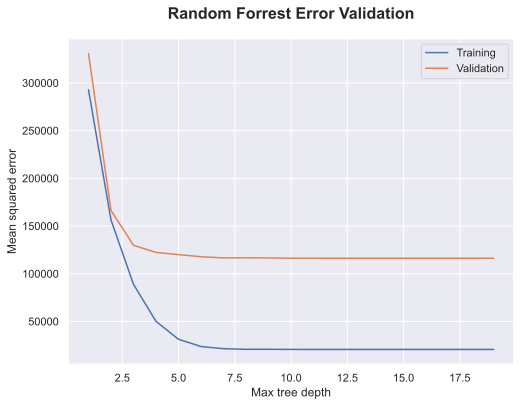

In [109]:
err_train_rf_bonn = []
err_val_rf_bonn = []

for depth in range(1, 20):
    # Fit model
    rf_regressor = RandomForestRegressor(n_estimators=1000, 
                                         bootstrap=True, # we select boostrapp, i.e. we use bagging
                                         random_state=42,
                                         max_depth=depth,
                                         criterion="mse") 
    rf_model = rf_regressor.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_rf_bonn.append(mean_squared_error(y_bonn_train, rf_model.predict(X_bonn_train)))
    err_val_rf_bonn.append(mean_squared_error(y_bonn_val, rf_model.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_rf_bonn, range(1, 20), err_val_rf_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Random Forrest Error Validation", fontsize=16, fontweight="bold", pad=20)

In [110]:
print("Best validation value for", np.argmin(err_val_rf_bonn)+1, "max depth")

Best validation value for 12 max depth


In [111]:
# sepcify and fit model

rf_regressor_bonn = RandomForestRegressor(n_estimators=1000, 
                                          bootstrap=True, # we select boostrapp, i.e. we use bagging
                                          random_state=42,
                                          max_depth=np.argmin(err_val_rf_bonn)+1,
                                          criterion="mse") 
rf_model_bonn = rf_regressor_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_rf = rf_model_bonn.predict(X_bonn_val)

In [112]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_rf))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_rf))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_rf))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_rf))

MSE: 116249.1779048516
MAE: 285.16287095238096
R2:  0.8437787192243839


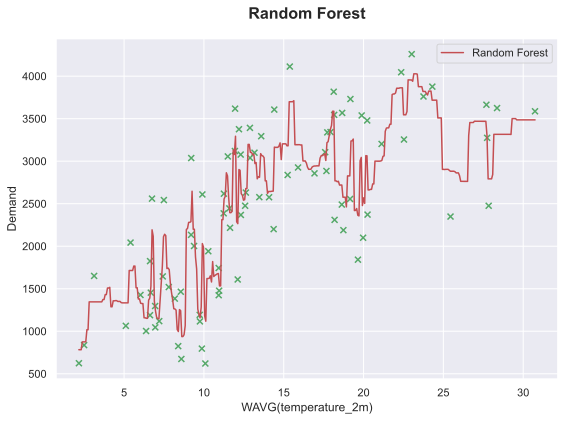

In [113]:
rf_feature = "WAVG(temperature_2m)"
rf_model_bonn = RandomForestRegressor(n_estimators=1000, 
                                      bootstrap=True, # we select boostrapp, i.e. we use bagging
                                      random_state=42,
                                      max_depth=np.argmin(err_val_rf_bonn)+1,
                                      criterion="mse").fit(X_bonn_train[rf_feature].values.reshape(-1, 1), 
                                                           y_bonn_train)
plot_scikit_output(X_bonn_train[rf_feature], 
                   y_bonn_train, 
                   rf_model_bonn, 
                   rf_feature, 
                   "Random Forest", 
                   "Bonn", 
                   "Random Forest")

#### Essen

Text(0.5, 1.0, 'Random Forrest Error Validation')

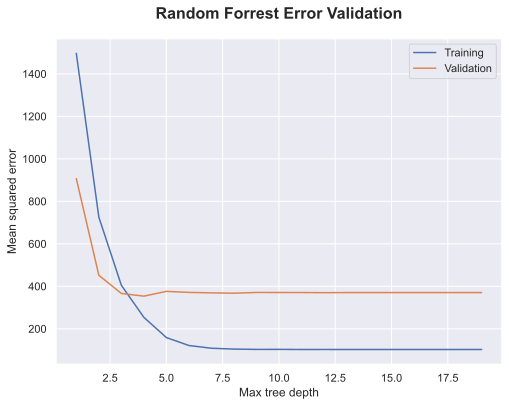

In [114]:
err_train_rf_essen = []
err_val_rf_essen = []

for depth in range(1, 20):
    # Fit model
    rf_regressor = RandomForestRegressor(n_estimators=1000, 
                                         bootstrap=True, # we select boostrapp, i.e. we use bagging
                                         random_state=42,
                                         max_depth=depth,
                                         criterion="mse") 
    rf_model = rf_regressor.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_rf_essen.append(mean_squared_error(y_essen_train, rf_model.predict(X_essen_train)))
    err_val_rf_essen.append(mean_squared_error(y_essen_val, rf_model.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_rf_essen, range(1, 20), err_val_rf_essen)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Random Forrest Error Validation", fontsize=16, fontweight="bold", pad=20)

In [115]:
print("Best validation value for", np.argmin(err_val_rf_essen)+1, "max depth")

Best validation value for 4 max depth


In [116]:
# sepcify and fit model

rf_regressor_essen = RandomForestRegressor(n_estimators=1000, 
                                           bootstrap=True, # we select boostrapp, i.e. we use bagging
                                           random_state=42,
                                           max_depth=np.argmin(err_val_rf_essen)+1,
                                           criterion="mse") 
rf_model_essen = rf_regressor_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_rf = rf_model_essen.predict(X_essen_val)

In [117]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_rf))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_rf))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_rf))
print("R2: ", r2_score(y_essen_val, y_essen_predict_rf))

MSE: 353.7276414089161
MAE: 14.400452256425602
R2:  0.8134959944767162


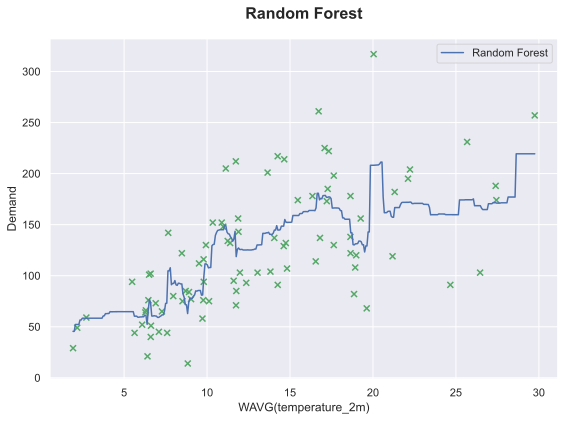

In [118]:
rf_feature = "WAVG(temperature_2m)"
rf_model_essen = RandomForestRegressor(n_estimators=1000, 
                                       bootstrap=True, # we select boostrapp, i.e. we use bagging
                                       random_state=1,
                                       max_depth=np.argmin(err_val_rf_essen)+1, 
                                       criterion="mse").fit(X_essen_train[rf_feature].values.reshape(-1, 1), 
                                                           y_essen_train)
plot_scikit_output(X_essen_train[rf_feature], 
                   y_essen_train, 
                   rf_model_essen, 
                   rf_feature, 
                   "Random Forest", 
                   "Essen", 
                   "Random Forest")

---

### RBF Regression

#### Bonn

CPU times: user 9.74 s, sys: 6.72 ms, total: 9.75 s
Wall time: 9.75 s


Text(0.5, 1.0, 'RBF Regression Error Validation')

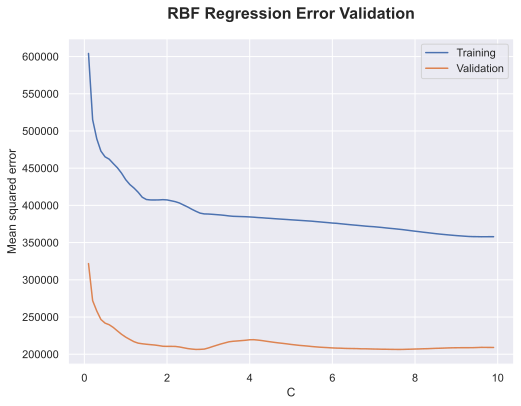

In [119]:
%%time
# Search the best degree and gamma
err_train_rbf = []
err_val_rbf = []
gammas = []
sc_X = StandardScaler()
sc_y = StandardScaler()
X_bonn_train_sc = sc_X.fit_transform(X_bonn_train)
y_bonn_train_sc = sc_y.fit_transform(y_bonn_train.values.reshape(-1, 1))
X_bonn_val_sc = sc_X.fit_transform(X_bonn_val)
y_bonn_val_sc = sc_y.fit_transform(y_bonn_val.values.reshape(-1, 1))
    
for C in np.arange(0.1, 10, 0.1):
    # Fit model
    err_val = []
    for gamma in np.arange(0.1, 10, 0.1):
        rbf_regressor_bonn = SVR(kernel='rbf', gamma=gamma, C=C)
        rbf_model_bonn = rbf_regressor_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)
        err_val.append(mean_squared_error(y_bonn_val, sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_val_sc))))
    
    gammas.append(np.argmin(err_val)/10)
    rbf_reg_bonn = SVR(kernel='rbf', C=C, gamma=np.argmin(err_val)/10+0.1)
    rbf_model_bonn = rbf_reg_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)
    
    # Compute errors
    err_train_rbf.append(mean_squared_error(y_bonn_train, sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_train_sc))))
    err_val_rbf.append(mean_squared_error(y_bonn_val, sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_val_sc))))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0.1, 10, 0.1), err_train_rbf, np.arange(0.1, 10, 0.1), err_val_rbf)
plt.legend(["Training", "Validation"])
plt.xlabel("C")
plt.ylabel("Mean squared error")
plt.title("RBF Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [120]:
print("Best validation value for C", np.argmin(err_val_rbf)/10+0.1, "and gamma", gammas[np.argmin(err_val_rbf)]+0.1)

Best validation value for C 7.6 and gamma 0.1


In [121]:
# Fit model (for the optimal C and gamma)
rbf_reg_bonn = SVR(kernel='rbf', gamma=gammas[np.argmin(err_val_rbf)]+0.1, C=np.argmin(err_val_rbf)/10+0.1)
rbf_model_bonn = rbf_reg_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)

# Predict
y_bonn_pred_rbf = sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_val_sc))

In [122]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_rbf))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_rbf))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_rbf))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_rbf))

MSE: 206430.73877711294
MAE: 341.97565481778787
R2:  0.7225883659184884


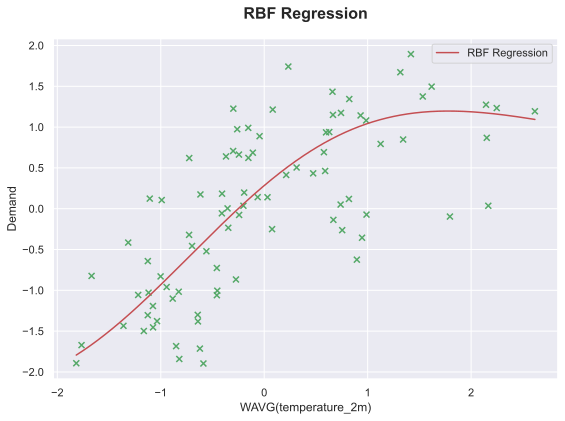

In [123]:
rbf_feature = "WAVG(temperature_2m)"
rbf_regressor_bonn = SVR(kernel='rbf', gamma=gammas[np.argmin(err_val_rbf)]+0.1, C=np.argmin(err_val_rbf)/10+0.1)

X_bonn_train_sc = sc_X.fit_transform(X_bonn_train[rbf_feature].values.reshape(-1, 1))
y_bonn_train_sc = sc_y.fit_transform(y_bonn_train.values.reshape(-1, 1))

rbf_model_bonn = rbf_regressor_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)
plot_scikit_output(X_bonn_train_sc, 
                   y_bonn_train_sc, 
                   rbf_model_bonn, 
                   rbf_feature, 
                   "RBF Regression", 
                   "Bonn", 
                   "RBF Regression")

#### Essen

CPU times: user 10 s, sys: 6.79 ms, total: 10.1 s
Wall time: 10.1 s


Text(0.5, 1.0, 'RBF Regression Error Validation')

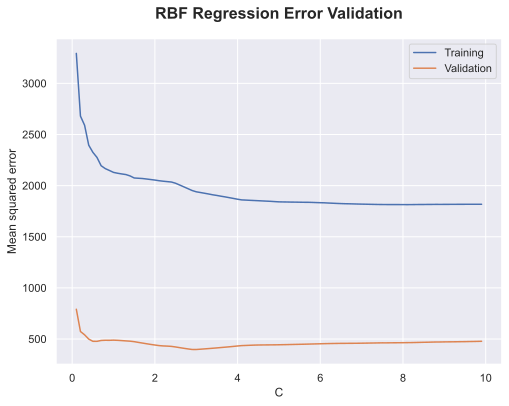

In [124]:
%%time
# Search the best degree and gamma
err_train_rbf = []
err_val_rbf = []
gammas = []
sc_X = StandardScaler()
sc_y = StandardScaler()
X_essen_train_sc = sc_X.fit_transform(X_essen_train)
y_essen_train_sc = sc_y.fit_transform(y_essen_train.values.reshape(-1, 1))
X_essen_val_sc = sc_X.fit_transform(X_essen_val)
y_essen_val_sc = sc_y.fit_transform(y_essen_val.values.reshape(-1, 1))
    
for C in np.arange(0.1, 10, 0.1):
    # Fit model
    err_val = []
    for gamma in np.arange(0.1, 10, 0.1):
        rbf_regressor_essen = SVR(kernel='rbf', gamma=gamma, C=C)
        rbf_model_essen = rbf_regressor_essen.fit(X_essen_train_sc, y_essen_train_sc)
        err_val.append(mean_squared_error(y_essen_val, sc_y.inverse_transform(rbf_model_essen.predict(X_essen_val_sc))))
    
    gammas.append(np.argmin(err_val)/10)
    rbf_reg_essen = SVR(kernel='rbf', C=C, gamma=np.argmin(err_val)/10+0.1)
    rbf_model_essen = rbf_reg_essen.fit(X_essen_train_sc, y_essen_train_sc)
    
    # Compute errors
    err_train_rbf.append(mean_squared_error(y_essen_train, sc_y.inverse_transform(rbf_model_essen.predict(X_essen_train_sc))))
    err_val_rbf.append(mean_squared_error(y_essen_val, sc_y.inverse_transform(rbf_model_essen.predict(X_essen_val_sc))))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0.1, 10, 0.1), err_train_rbf, np.arange(0.1, 10, 0.1), err_val_rbf)
plt.legend(["Training", "Validation"])
plt.xlabel("C")
plt.ylabel("Mean squared error")
plt.title("RBF Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [125]:
print("Best validation value for C", np.argmin(err_val_rbf)/10+0.1, "and gamma", gammas[np.argmin(err_val_rbf)]+0.1)

Best validation value for C 3.0 and gamma 0.1


In [126]:
# Fit model (for the optimal C and gamma)
rbf_reg_essen = SVR(kernel='rbf', gamma=gammas[np.argmin(err_val_rbf)]+0.1, C=np.argmin(err_val_rbf)/10+0.1)
rbf_model_essen = rbf_reg_essen.fit(X_essen_train_sc, y_essen_train_sc)

# Predict
y_essen_pred_rbf = sc_y.inverse_transform(rbf_model_essen.predict(X_essen_val_sc))

In [127]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_rbf))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_rbf))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_rbf))
print("R2: ", r2_score(y_essen_val, y_essen_pred_rbf))

MSE: 397.41432992129444
MAE: 14.281384332589637
R2:  0.7904620512905018


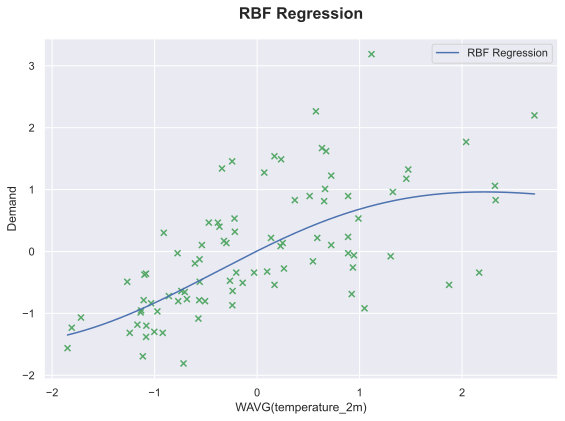

In [128]:
rbf_feature = "WAVG(temperature_2m)"
rbf_regressor_essen = SVR(kernel='rbf', gamma=gammas[np.argmin(err_val_rbf)]+0.1, C=np.argmin(err_val_rbf)/10+0.1)

X_essen_train_sc = sc_X.fit_transform(X_essen_train[rbf_feature].values.reshape(-1, 1))
y_essen_train_sc = sc_y.fit_transform(y_essen_train.values.reshape(-1, 1))

rbf_model_essen = rbf_regressor_essen.fit(X_essen_train_sc, y_essen_train_sc)
plot_scikit_output(X_essen_train_sc, 
                   y_essen_train_sc, 
                   rbf_model_essen, 
                   rbf_feature, 
                   "RBF Regression", 
                   "essen", 
                   "RBF Regression")

---

### K-Nearest-Neighbor (KNN) Regression

#### Bonn

Which number of neighbors $k$ is optimal?

Text(0.5, 1.0, 'KNN Regression Error Validation')

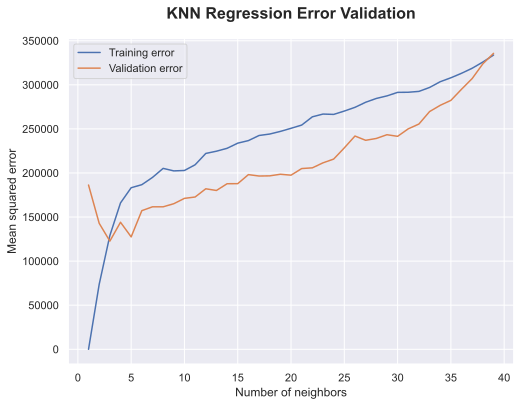

In [129]:
# Search the best number of neighbors
err_train_knn_bonn = [] 
err_val_knn_bonn = []

for k in range(1, 40):

    # Fit model
    KNN_reg = KNeighborsRegressor(n_neighbors=k)
    KNN_model = KNN_reg.fit(X_bonn_train, y_bonn_train)

    # Compute errors
    err_train_knn_bonn.append(mean_squared_error(y_bonn_train, KNN_model.predict(X_bonn_train)))
    err_val_knn_bonn.append(mean_squared_error(y_bonn_val, KNN_model.predict(X_bonn_val)))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), err_train_knn_bonn, label="Training error")
plt.plot(range(1, 40), err_val_knn_bonn, label="Validation error")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Mean squared error")
plt.title("KNN Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [130]:
print("Best validation value for", np.argmin(err_val_knn_bonn)+1, "neighbors")

Best validation value for 3 neighbors


Train model with optimal $k$.

In [131]:
# Fit model (for the optimal number of neighbors)
KNN_reg_bonn = KNeighborsRegressor(n_neighbors=np.argmin(err_val_knn_bonn)+1)
KNN_model_bonn = KNN_reg_bonn.fit(X_bonn_train, y_bonn_train)

# Predict
y_bonn_pred_knn = KNN_model_bonn.predict(X_bonn_val)

In [132]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_knn))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_knn))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_knn))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_knn))

MSE: 122721.65185185181
MAE: 266.0888888888889
R2:  0.8350806949629582


Plot for a single feature:

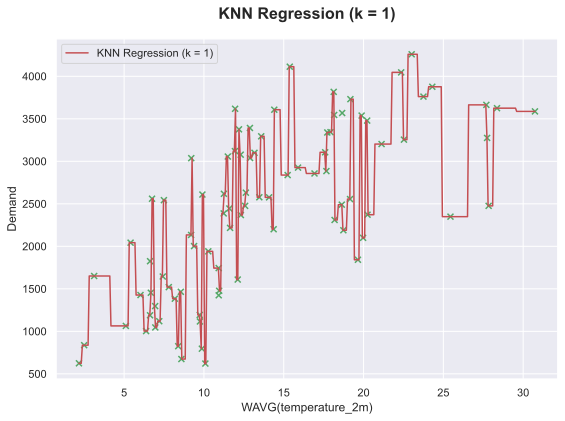

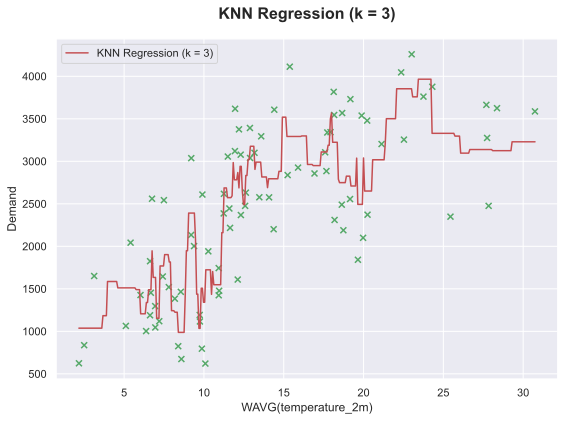

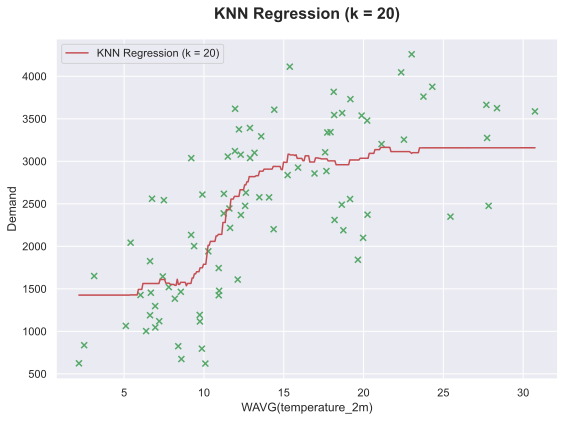

In [133]:
knn_feature = "WAVG(temperature_2m)"
for k in (1, np.argmin(err_val_knn_bonn)+1, 20):
    KNN_reg_bonn = KNeighborsRegressor(n_neighbors=k)
    KNN_model_bonn = KNN_reg_bonn.fit(X_bonn_train[knn_feature].values.reshape(-1, 1), y_bonn_train)
    plot_scikit_output(X_bonn_train[knn_feature], 
                       y_bonn_train, 
                       KNN_model_bonn, 
                       knn_feature, 
                       f"KNN Regression (k = {k})",
                       "Bonn",
                       f"KNN Regression (k = {k})")

#### Essen

Which number of neighbors $k$ is optimal?

Text(0.5, 1.0, 'KNN Regression Error Validation')

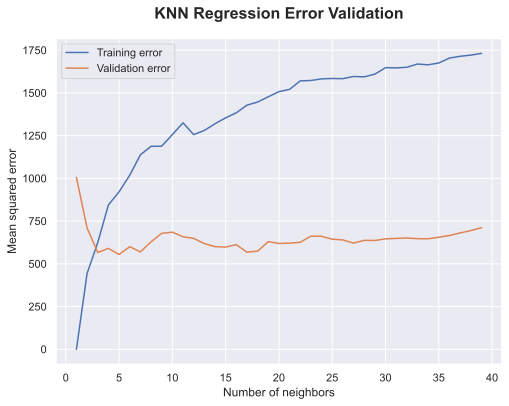

In [134]:
# Search the best number of neighbors
err_train_knn_essen = [] 
err_val_knn_essen = []

for k in range(1, 40):

    # Fit model
    KNN_reg = KNeighborsRegressor(n_neighbors=k)
    KNN_model = KNN_reg.fit(X_essen_train, y_essen_train)

    # Compute errors
    err_train_knn_essen.append(mean_squared_error(y_essen_train, KNN_model.predict(X_essen_train)))
    err_val_knn_essen.append(mean_squared_error(y_essen_val, KNN_model.predict(X_essen_val)))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), err_train_knn_essen, label="Training error")
plt.plot(range(1, 40), err_val_knn_essen, label="Validation error")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Mean squared error")
plt.title("KNN Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [135]:
print("Best validation value for", np.argmin(err_val_knn_essen)+1, "neighbors")

Best validation value for 5 neighbors


Train model with optimal $k$.

In [136]:
# Fit model (for the optimal number of neighbors)
KNN_reg_essen = KNeighborsRegressor(n_neighbors=np.argmin(err_val_knn_essen)+1)
KNN_model_essen = KNN_reg_essen.fit(X_essen_train, y_essen_train)

# Predict
y_essen_pred_knn = KNN_model_essen.predict(X_essen_val)

In [137]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_knn))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_knn))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_knn))
print("R2: ", r2_score(y_essen_val, y_essen_pred_knn))

MSE: 554.8906666666667
MAE: 17.94666666666667
R2:  0.7074321600974831


Plot for a single feature:

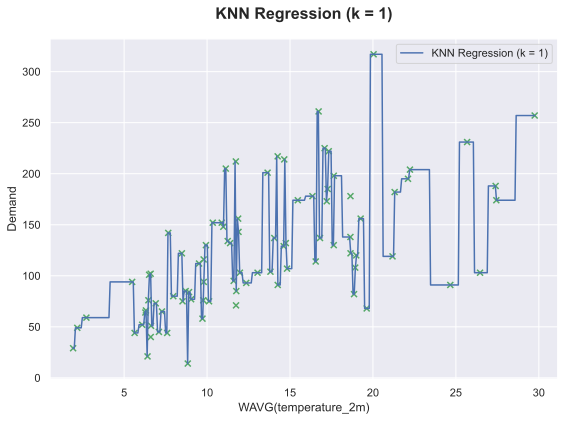

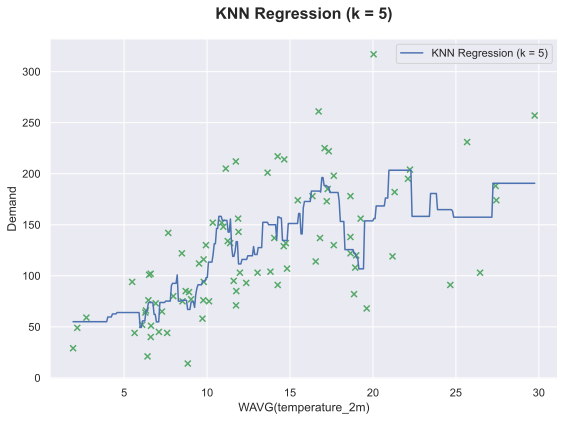

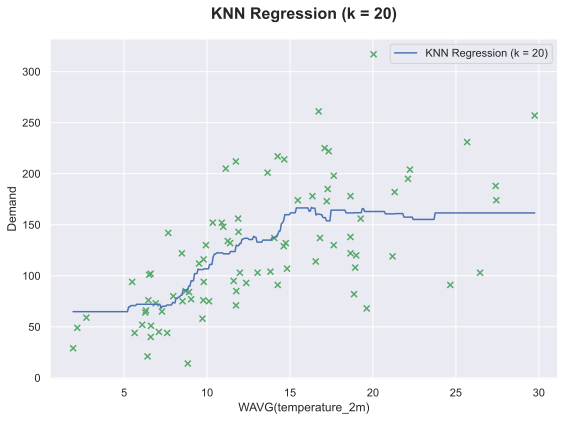

In [138]:
knn_feature = "WAVG(temperature_2m)"
for k in (1, np.argmin(err_val_knn_essen)+1, 20):
    KNN_reg_essen = KNeighborsRegressor(n_neighbors=k)
    KNN_model_essen = KNN_reg_essen.fit(X_essen_train[knn_feature].values.reshape(-1, 1), y_essen_train)
    plot_scikit_output(X_essen_train[knn_feature], 
                       y_essen_train, 
                       KNN_model_essen, 
                       knn_feature, 
                       f"KNN Regression (k = {k})",
                       "Essen",
                       f"KNN Regression (k = {k})")

---

### Neural Network

#### Bonn

In [139]:
# Normalizing training data
st_scaler = StandardScaler()
st_scaler.fit(X_bonn_train)
X_bonn_train_scaled = st_scaler.transform(X_bonn_train)
st_scaler.fit(X_bonn_val)
X_bonn_val_scaled = st_scaler.transform(X_bonn_val)

network_bonn = Sequential()
network_bonn.add(Dense(input_shape=[X_bonn_train.shape[1]], units=360, activation="relu"))
network_bonn.add(Dropout(rate=0.1))
network_bonn.add(Dense(units=360, activation="relu"))
network_bonn.add(Dropout(rate=0.1))
network_bonn.add(Dense(1))

# Compiling the ANN
network_bonn.compile(loss='mse', 
                     optimizer="adam",
                     metrics=["mae", "mse"])

network_bonn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 360)               3240      
_________________________________________________________________
dropout (Dropout)            (None, 360)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 360)               129960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 360)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 361       
Total params: 133,561
Trainable params: 133,561
Non-trainable params: 0
_________________________________________________________________


In [140]:
%%time
history_bonn = network_bonn.fit(X_bonn_train_scaled, y_bonn_train.values, 
                                validation_data = (X_bonn_val_scaled, y_bonn_val.values),
                                epochs=200)

Epoch 1/200
3/3 [==============================] - 1s 287ms/step - loss: 6760716.0000 - mae: 2417.6652 - mse: 6760716.0000 - val_loss: 4258267.5000 - val_mae: 1874.5691 - val_mse: 4258267.5000
Epoch 2/200
3/3 [==============================] - 0s 22ms/step - loss: 6718404.3750 - mae: 2410.9496 - mse: 6718404.3750 - val_loss: 4254340.5000 - val_mae: 1873.5370 - val_mse: 4254340.5000
Epoch 3/200
3/3 [==============================] - 0s 21ms/step - loss: 6756120.0000 - mae: 2424.2764 - mse: 6756120.0000 - val_loss: 4249901.0000 - val_mae: 1872.3817 - val_mse: 4249901.0000
Epoch 4/200
3/3 [==============================] - 0s 21ms/step - loss: 6904638.5000 - mae: 2446.2434 - mse: 6904638.5000 - val_loss: 4244566.5000 - val_mae: 1871.0060 - val_mse: 4244566.5000
Epoch 5/200
3/3 [==============================] - 0s 21ms/step - loss: 7356061.3750 - mae: 2537.2266 - mse: 7356061.3750 - val_loss: 4238113.5000 - val_mae: 1869.3563 - val_mse: 4238113.5000
Epoch 6/200
3/3 [======================

3/3 [==============================] - 0s 26ms/step - loss: 2195643.9062 - mae: 1342.3784 - mse: 2195643.9062 - val_loss: 905871.9375 - val_mae: 808.3856 - val_mse: 905871.9375
Epoch 44/200
3/3 [==============================] - 0s 28ms/step - loss: 2018702.6562 - mae: 1279.2409 - mse: 2018702.6562 - val_loss: 784983.4375 - val_mae: 750.9990 - val_mse: 784983.4375
Epoch 45/200
3/3 [==============================] - 0s 28ms/step - loss: 1774735.9688 - mae: 1201.9679 - mse: 1774735.9688 - val_loss: 676867.2500 - val_mae: 697.2988 - val_mse: 676867.2500
Epoch 46/200
3/3 [==============================] - 0s 29ms/step - loss: 1693761.1562 - mae: 1160.1723 - mse: 1693761.1562 - val_loss: 581010.3750 - val_mae: 645.5855 - val_mse: 581010.3750
Epoch 47/200
3/3 [==============================] - 0s 24ms/step - loss: 1368966.3125 - mae: 1035.7831 - mse: 1368966.3125 - val_loss: 499415.1875 - val_mae: 593.9001 - val_mse: 499415.1875
Epoch 48/200
3/3 [==============================] - 0s 21ms/ste

Epoch 87/200
3/3 [==============================] - 0s 21ms/step - loss: 251086.3945 - mae: 394.6229 - mse: 251086.3945 - val_loss: 450453.9062 - val_mae: 517.4070 - val_mse: 450453.9062
Epoch 88/200
3/3 [==============================] - 0s 21ms/step - loss: 249325.1094 - mae: 399.8887 - mse: 249325.1094 - val_loss: 450641.3750 - val_mae: 517.9410 - val_mse: 450641.3750
Epoch 89/200
3/3 [==============================] - 0s 21ms/step - loss: 238088.8477 - mae: 392.4334 - mse: 238088.8477 - val_loss: 452166.4688 - val_mae: 519.1283 - val_mse: 452166.4688
Epoch 90/200
3/3 [==============================] - 0s 21ms/step - loss: 259114.1406 - mae: 414.5289 - mse: 259114.1406 - val_loss: 450516.6562 - val_mae: 518.2806 - val_mse: 450516.6562
Epoch 91/200
3/3 [==============================] - 0s 21ms/step - loss: 238842.0078 - mae: 407.0208 - mse: 238842.0078 - val_loss: 450040.5625 - val_mae: 518.2036 - val_mse: 450040.5625
Epoch 92/200
3/3 [==============================] - 0s 21ms/step 

Epoch 131/200
3/3 [==============================] - 0s 21ms/step - loss: 190839.3945 - mae: 351.8685 - mse: 190839.3945 - val_loss: 447882.8750 - val_mae: 527.0292 - val_mse: 447882.8750
Epoch 132/200
3/3 [==============================] - 0s 21ms/step - loss: 160647.7617 - mae: 324.2444 - mse: 160647.7617 - val_loss: 446568.7188 - val_mae: 526.4210 - val_mse: 446568.7188
Epoch 133/200
3/3 [==============================] - 0s 21ms/step - loss: 200700.0977 - mae: 357.8501 - mse: 200700.0977 - val_loss: 444383.3438 - val_mae: 525.3090 - val_mse: 444383.3438
Epoch 134/200
3/3 [==============================] - 0s 21ms/step - loss: 175558.1328 - mae: 345.2215 - mse: 175558.1328 - val_loss: 442541.6875 - val_mae: 524.4169 - val_mse: 442541.6875
Epoch 135/200
3/3 [==============================] - 0s 21ms/step - loss: 185250.4062 - mae: 350.0374 - mse: 185250.4062 - val_loss: 441620.1875 - val_mae: 524.5940 - val_mse: 441620.1875
Epoch 136/200
3/3 [==============================] - 0s 21ms

3/3 [==============================] - 0s 27ms/step - loss: 155225.6250 - mae: 326.4991 - mse: 155225.6250 - val_loss: 443092.1562 - val_mae: 535.1759 - val_mse: 443092.1562
Epoch 175/200
3/3 [==============================] - 0s 26ms/step - loss: 187763.2734 - mae: 348.1588 - mse: 187763.2734 - val_loss: 441008.4688 - val_mae: 533.9465 - val_mse: 441008.4688
Epoch 176/200
3/3 [==============================] - 0s 27ms/step - loss: 141869.0840 - mae: 303.8209 - mse: 141869.0840 - val_loss: 441355.6562 - val_mae: 534.3439 - val_mse: 441355.6562
Epoch 177/200
3/3 [==============================] - 0s 28ms/step - loss: 151215.7812 - mae: 315.9928 - mse: 151215.7812 - val_loss: 440770.6562 - val_mae: 534.4907 - val_mse: 440770.6562
Epoch 178/200
3/3 [==============================] - 0s 28ms/step - loss: 169241.3828 - mae: 341.8150 - mse: 169241.3828 - val_loss: 440820.0312 - val_mae: 534.8031 - val_mse: 440820.0312
Epoch 179/200
3/3 [==============================] - 0s 24ms/step - loss: 

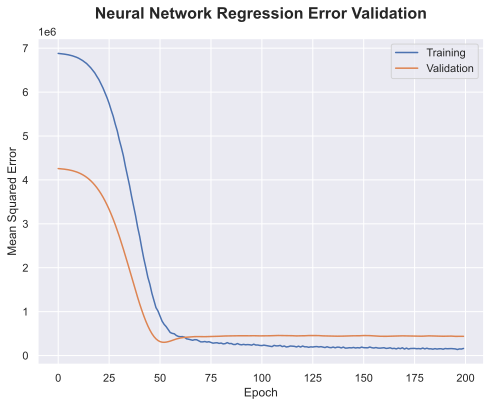

In [141]:
plt.figure(figsize=(8, 6))

plt.plot(history_bonn.history['mse'])
plt.plot(history_bonn.history['val_mse'])
plt.legend(['Training', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Neural Network Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

plt.show()

In [142]:
# Predict on validation set
y_bonn_pred_network = network_bonn.predict(X_bonn_val_scaled)

In [143]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_network))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_network))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_network))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_network))

MSE: 437311.872318792
MAE: 536.0594299316406
R2:  0.4123191060504421


#### Essen

In [144]:
# Normalizing training data
st_scaler = StandardScaler()
st_scaler.fit(X_essen_train)
X_essen_train_scaled = st_scaler.transform(X_essen_train)
st_scaler.fit(X_essen_val)
X_essen_val_scaled = st_scaler.transform(X_essen_val)

network_essen = Sequential()
network_essen.add(Dense(input_shape=[X_essen_train.shape[1]], units=36, activation="relu"))
network_essen.add(Dropout(rate=0.1))
network_essen.add(Dense(units=36, activation="relu"))
network_essen.add(Dropout(rate=0.1))
network_essen.add(Dense(1))

# Compiling the ANN
network_essen.compile(loss='mse', 
                     optimizer="adam",
                     metrics=["mae", "mse"])

network_essen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 36)                324       
_________________________________________________________________
dropout_2 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 36)                1332      
_________________________________________________________________
dropout_3 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 37        
Total params: 1,693
Trainable params: 1,693
Non-trainable params: 0
_________________________________________________________________


In [145]:
%%time
history_essen = network_essen.fit(X_essen_train_scaled, y_essen_train.values, 
                                validation_data = (X_essen_val_scaled, y_essen_val.values),
                                epochs=200)

Epoch 1/200
3/3 [==============================] - 0s 69ms/step - loss: 18051.3606 - mae: 120.3617 - mse: 18051.3606 - val_loss: 10063.0020 - val_mae: 90.3728 - val_mse: 10063.0020
Epoch 2/200
3/3 [==============================] - 0s 19ms/step - loss: 18536.9058 - mae: 122.1612 - mse: 18536.9058 - val_loss: 10046.5488 - val_mae: 90.2879 - val_mse: 10046.5488
Epoch 3/200
3/3 [==============================] - 0s 19ms/step - loss: 20212.9653 - mae: 127.5615 - mse: 20212.9653 - val_loss: 10029.9463 - val_mae: 90.2023 - val_mse: 10029.9463
Epoch 4/200
3/3 [==============================] - 0s 19ms/step - loss: 19218.4165 - mae: 123.5181 - mse: 19218.4165 - val_loss: 10013.4795 - val_mae: 90.1175 - val_mse: 10013.4795
Epoch 5/200
3/3 [==============================] - 0s 19ms/step - loss: 19140.8438 - mae: 123.4507 - mse: 19140.8438 - val_loss: 9996.8965 - val_mae: 90.0324 - val_mse: 9996.8965
Epoch 6/200
3/3 [==============================] - 0s 20ms/step - loss: 19274.6646 - mae: 124.508

3/3 [==============================] - 0s 19ms/step - loss: 15993.7876 - mae: 110.9980 - mse: 15993.7876 - val_loss: 6758.1533 - val_mae: 73.0325 - val_mse: 6758.1533
Epoch 47/200
3/3 [==============================] - 0s 20ms/step - loss: 13684.4072 - mae: 103.4646 - mse: 13684.4072 - val_loss: 6561.0479 - val_mae: 71.9011 - val_mse: 6561.0479
Epoch 48/200
3/3 [==============================] - 0s 19ms/step - loss: 13919.4292 - mae: 104.6800 - mse: 13919.4292 - val_loss: 6356.1069 - val_mae: 70.7126 - val_mse: 6356.1069
Epoch 49/200
3/3 [==============================] - 0s 19ms/step - loss: 13087.4961 - mae: 100.6311 - mse: 13087.4961 - val_loss: 6144.8599 - val_mae: 69.4701 - val_mse: 6144.8599
Epoch 50/200
3/3 [==============================] - 0s 19ms/step - loss: 12891.6670 - mae: 99.5641 - mse: 12891.6670 - val_loss: 5927.8960 - val_mae: 68.1730 - val_mse: 5927.8960
Epoch 51/200
3/3 [==============================] - 0s 20ms/step - loss: 12918.7783 - mae: 100.1232 - mse: 12918.7

3/3 [==============================] - 0s 20ms/step - loss: 1528.6126 - mae: 30.1498 - mse: 1528.6126 - val_loss: 860.9250 - val_mae: 21.9053 - val_mse: 860.9250
Epoch 93/200
3/3 [==============================] - 0s 20ms/step - loss: 2095.2405 - mae: 35.1018 - mse: 2095.2405 - val_loss: 910.9810 - val_mae: 22.3858 - val_mse: 910.9810
Epoch 94/200
3/3 [==============================] - 0s 20ms/step - loss: 1536.0031 - mae: 31.0011 - mse: 1536.0031 - val_loss: 952.3560 - val_mae: 22.7522 - val_mse: 952.3560
Epoch 95/200
3/3 [==============================] - 0s 20ms/step - loss: 1303.1060 - mae: 28.2996 - mse: 1303.1060 - val_loss: 995.1698 - val_mae: 23.1170 - val_mse: 995.1698
Epoch 96/200
3/3 [==============================] - 0s 20ms/step - loss: 1976.1714 - mae: 31.8848 - mse: 1976.1714 - val_loss: 1033.6244 - val_mae: 23.4277 - val_mse: 1033.6244
Epoch 97/200
3/3 [==============================] - 0s 20ms/step - loss: 1678.5323 - mae: 31.1776 - mse: 1678.5323 - val_loss: 1062.6819

3/3 [==============================] - 0s 27ms/step - loss: 1314.6412 - mae: 24.9229 - mse: 1314.6412 - val_loss: 1214.2191 - val_mae: 27.1991 - val_mse: 1214.2191
Epoch 139/200
3/3 [==============================] - 0s 24ms/step - loss: 1480.5200 - mae: 27.5896 - mse: 1480.5200 - val_loss: 1208.4943 - val_mae: 27.1738 - val_mse: 1208.4943
Epoch 140/200
3/3 [==============================] - 0s 22ms/step - loss: 1559.6617 - mae: 27.6037 - mse: 1559.6617 - val_loss: 1203.1573 - val_mae: 27.1447 - val_mse: 1203.1573
Epoch 141/200
3/3 [==============================] - 0s 26ms/step - loss: 1206.5618 - mae: 26.2759 - mse: 1206.5618 - val_loss: 1193.8137 - val_mae: 27.0568 - val_mse: 1193.8137
Epoch 142/200
3/3 [==============================] - 0s 24ms/step - loss: 1186.0097 - mae: 26.0046 - mse: 1186.0097 - val_loss: 1180.8986 - val_mae: 26.9350 - val_mse: 1180.8986
Epoch 143/200
3/3 [==============================] - 0s 26ms/step - loss: 1080.5108 - mae: 24.6558 - mse: 1080.5108 - val_lo

3/3 [==============================] - 0s 25ms/step - loss: 1261.5644 - mae: 25.8655 - mse: 1261.5644 - val_loss: 1162.4062 - val_mae: 27.3419 - val_mse: 1162.4062
Epoch 185/200
3/3 [==============================] - 0s 26ms/step - loss: 1153.2484 - mae: 23.5480 - mse: 1153.2484 - val_loss: 1165.7048 - val_mae: 27.3868 - val_mse: 1165.7048
Epoch 186/200
3/3 [==============================] - 0s 25ms/step - loss: 1112.3408 - mae: 23.8881 - mse: 1112.3408 - val_loss: 1164.8065 - val_mae: 27.3809 - val_mse: 1164.8065
Epoch 187/200
3/3 [==============================] - 0s 26ms/step - loss: 1312.8914 - mae: 24.4869 - mse: 1312.8914 - val_loss: 1171.0696 - val_mae: 27.4586 - val_mse: 1171.0696
Epoch 188/200
3/3 [==============================] - 0s 26ms/step - loss: 1346.2733 - mae: 26.3554 - mse: 1346.2733 - val_loss: 1167.7673 - val_mae: 27.4389 - val_mse: 1167.7673
Epoch 189/200
3/3 [==============================] - 0s 27ms/step - loss: 972.4814 - mae: 22.9026 - mse: 972.4814 - val_loss

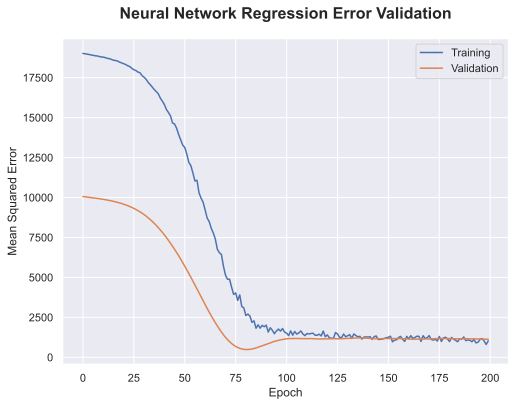

In [146]:
plt.figure(figsize=(8, 6))

plt.plot(history_essen.history['mse'])
plt.plot(history_essen.history['val_mse'])
plt.legend(['Training', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Neural Network Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

plt.show()

In [147]:
# Predict on validation set
y_essen_pred_network = network_essen.predict(X_essen_val_scaled)

In [148]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_network))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_network))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_network))
print("R2: ", r2_score(y_essen_val, y_essen_pred_network))

MSE: 1130.5915747674483
MAE: 27.17611134847005
R2:  0.40389205529672423


---

## $\mathrm{R^2}$ Scores

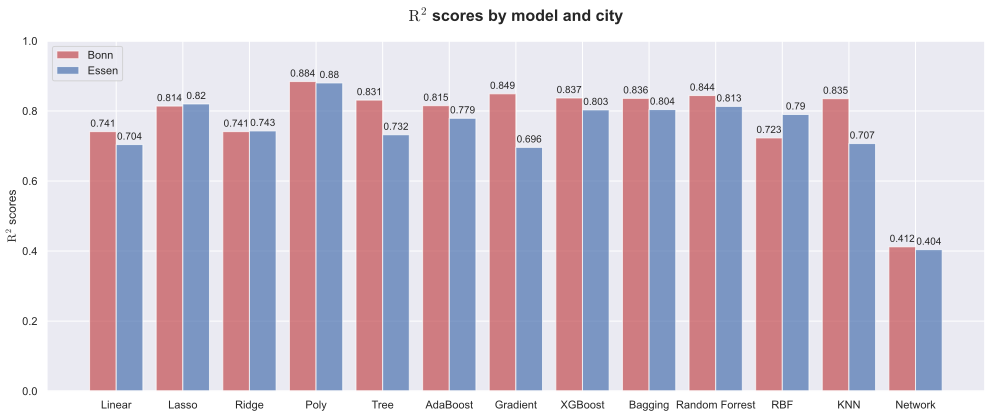

In [156]:
labels = ['Linear', 'Lasso', 'Ridge', 'Poly', 'Tree', 'AdaBoost', 'Gradient', 'XGBoost', 'Bagging', 'Random Forrest', 'RBF', 'KNN', 'Network']
r2_bonn_rounded = [ round(elem, 3) for elem in r2_bonn ]
r2_essen_rounded = [ round(elem, 3) for elem in r2_essen ]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, r2_bonn_rounded, width, label='Bonn', color='C3', alpha=0.7)
rects2 = ax.bar(x + width/2, r2_essen_rounded, width, label='Essen', color='C0', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\mathrm{R^2}$ scores')
ax.set_ylim([0, 1])
ax.set_title('$\mathrm{R^2}$ scores by model and city', fontsize=16, fontweight="bold", pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=2)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# fig.savefig("r2_scores.pdf", bbox_inches='tight')

---

## Testing the selected model

We test the poly regression with the test data set as poly regression has the best validation score for both cities.

#### Bonn

In [150]:
# Fit model (for the optimal degree and alpha)
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_bonn)+1)
X_poly_train = poly.fit_transform(X_bonn_train)
X_poly_val = poly.transform(X_bonn_val)
X_poly_test = poly.transform(X_bonn_test)
poly_reg_bonn = Lasso(alpha=alphas_poly_bonn[np.argmin(err_val_poly_bonn)])
poly_model_bonn = poly_reg_bonn.fit(X_poly_train, y_bonn_train)

# Predict
y_bonn_pred_poly_train = poly_model_bonn.predict(X_poly_train)
y_bonn_pred_poly_val = poly_model_bonn.predict(X_poly_val)
y_bonn_pred_poly_test = poly_model_bonn.predict(X_poly_test)

In [151]:
print("Training performance:")
print("MSE:", mean_squared_error(y_bonn_train, y_bonn_pred_poly_train))
print("MAE:", mean_absolute_error(y_bonn_train, y_bonn_pred_poly_train))
print("R2: ", r2_score(y_bonn_train, y_bonn_pred_poly_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_poly_val))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_poly_val))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_poly_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_bonn_test, y_bonn_pred_poly_test))
print("MAE:", mean_absolute_error(y_bonn_test, y_bonn_pred_poly_test))
print("R2: ", r2_score(y_bonn_test, y_bonn_pred_poly_test))

Training performance:
MSE: 17386.17709683584
MAE: 84.34874843638099
R2:  0.98112885307464

Validation performance:
MSE: 86344.88067104101
MAE: 234.44489376912472
R2:  0.8839655635424084

Test performance:
MSE: 225147.5329930422
MAE: 339.8908894018238
R2:  0.7152566268951672


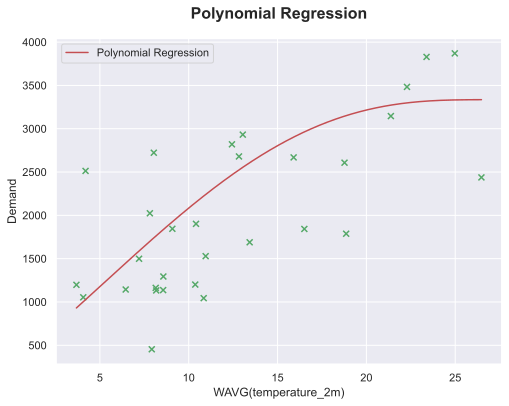

In [152]:
poly_feature = "WAVG(temperature_2m)"
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_bonn)+1)
X_poly_train = poly.fit_transform(X_bonn_train[poly_feature].values.reshape(-1,1))

poly_bonn = Lasso(alpha=alphas_poly_bonn[np.argmin(err_val_poly_bonn)]).fit(X_poly_train, y_bonn_train)
plot_scikit_poly_output(X_bonn_test[poly_feature], y_bonn_test, poly_bonn, poly, poly_feature, "Polynomial Regression", "Bonn", "Polynomial Regression")

#### Essen

In [153]:
# Fit model (for the optimal degree and alpha)
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_essen)+1)
X_poly_train = poly.fit_transform(X_essen_train)
X_poly_val = poly.transform(X_essen_val)
X_poly_test = poly.transform(X_essen_test)
poly_reg_essen = Lasso(alpha=alphas_poly_essen[np.argmin(err_val_poly_essen)])
poly_model_essen = poly_reg_essen.fit(X_poly_train, y_essen_train)

# Predict
y_essen_pred_poly_train = poly_model_essen.predict(X_poly_train)
y_essen_pred_poly_val = poly_model_essen.predict(X_poly_val)
y_essen_pred_poly_test = poly_model_essen.predict(X_poly_test)

In [154]:
print("Training performance:")
print("MSE:", mean_squared_error(y_essen_train, y_essen_pred_poly_train))
print("MAE:", mean_absolute_error(y_essen_train, y_essen_pred_poly_train))
print("R2: ", r2_score(y_essen_train, y_essen_pred_poly_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_poly_val))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_poly_val))
print("R2: ", r2_score(y_essen_val, y_essen_pred_poly_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_essen_test, y_essen_pred_poly_test))
print("MAE:", mean_absolute_error(y_essen_test, y_essen_pred_poly_test))
print("R2: ", r2_score(y_essen_test, y_essen_pred_poly_test))

Training performance:
MSE: 544.5960203971662
MAE: 16.80113860353653
R2:  0.851902145361222

Validation performance:
MSE: 227.82889661123164
MAE: 12.273183078500779
R2:  0.8798765015289705

Test performance:
MSE: 507.0261650483264
MAE: 18.054358049712093
R2:  0.8861756728974158


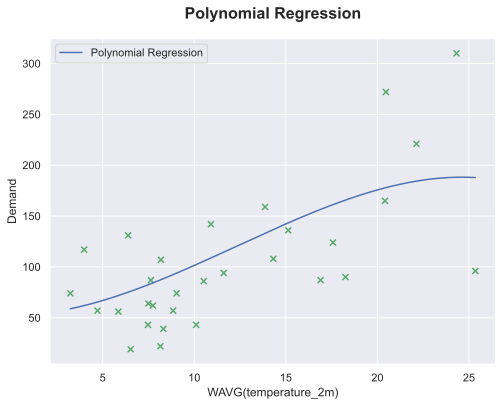

In [155]:
poly_feature = "WAVG(temperature_2m)"
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_essen)+1)
X_poly_train = poly.fit_transform(X_essen_train[poly_feature].values.reshape(-1,1))

poly_essen = Lasso(alpha=alphas_poly_essen[np.argmin(err_val_poly_essen)]).fit(X_poly_train, y_essen_train)
plot_scikit_poly_output(X_essen_test[poly_feature], y_essen_test, poly_essen, poly, poly_feature, "Polynomial Regression", "essen", "Polynomial Regression")

---

## Experiment: Which subset of features produces the optimal model?  
We asked ourselves the question what would be the best feature selection we could have chosen. To find out we iterated over all possible feature subsets and validated them on a simple linear regression model. For the sake of simplicity we performed this experiment only for the dataset of Bonn.

In [50]:
# Features we picked for examination
# If we pick all_features, there are 22 features => 2**22=4.194.304 possible subsets 
# Careful: Picking all features leads to a long algorithm runtime!!
relevant_features = [ 
    'isHoliday',
    'isWeekend', 
    'isSemester', 
    'isSchool',
    'isKarneval', 
    'WAVG(temperature_2m)', 
    'WAVG(dew_point_temperature_2m)',
    'WAVG(relative_humidity)', 
    'WAVG(precipitation)',
    'WAVG(has_precipitated)', 
    'WAVG(wind_velocity_10m)',
    'WAVG(wind_direction_10m)', 
    'WAVG(mean_wind_speed_10m)',
    'WAVG(mean_wind_direction_10m)',
    'WAVG(air_pressure_station_level)',
    'WAVG(air_pressure_sea_level)', 
    'WAVG(cloud_coverage)',
    'WAVG(soil_temperature_5cm)', 
    'WAVG(soil_temperature_10cm)',
    'WAVG(soil_temperature_20cm)', 
    'WAVG(soil_temperature_50cm)',
    'WAVG(soil_temperature_100cm)'
]

def powerset(s):
    p = (combinations(s, r) for r in range(1,len(s)+1)) 
    p = chain.from_iterable(p)
    p = list(p)
    return p

In [26]:
%%time
# Create training, validation and test data:
X, y = df_bonn.drop("demand", axis=1), df_bonn["demand"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

score_val_feature_sets = dict()

for feature_set in tqdm(powerset(relevant_features)):   
    feature_set = list(feature_set)
    # Evaluate this feature set by fitting linear regression and calculating the score using validation data
    # => Optimal with respect to simple linear regression model.
    # We could also optimize a regularized linear regression model or even linear regression model on non-linear data.
    lr = LinearRegression(normalize=True).fit(X_train[feature_set], y_train)
    score = lr.score(X_val[feature_set], y_val)
    score_val_feature_sets[", ".join(feature_set)] = score

scores = pd.DataFrame(score_val_feature_sets.values(), index=score_val_feature_sets.keys())
scores = scores.sort_values(0, ascending=False)
scores["len"] = scores.index.map(lambda s: len(s.split(","))) # how big is the subset (relevant_features has length 22)
scores = scores.reset_index()
scores = scores.rename(columns={0: "score", "index": "feature_set"})
scores


CPU times: user 18h 8min 56s, sys: 20min 2s, total: 18h 28min 59s
Wall time: 4h 37min 6s


feature_set     score  len
0        isWeekend, isSemester, isKarneval, WAVG(temper...  0.874316   12
1        isWeekend, isSemester, isKarneval, WAVG(temper...  0.874308   11
2        isWeekend, isSemester, isKarneval, WAVG(temper...  0.874186   12
3        isWeekend, isSemester, isKarneval, WAVG(temper...  0.873956   13
4        isWeekend, isSemester, isKarneval, WAVG(temper...  0.873942   14
...                                                    ...       ...  ...
4194298  isWeekend, isSchool, WAVG(mean_wind_direction_... -0.321735    5
4194299  isHoliday, isWeekend, WAVG(air_pressure_statio... -0.321918    4
4194300  isWeekend, WAVG(mean_wind_direction_10m), WAVG... -0.322368    4
4194301  isHoliday, isWeekend, WAVG(wind_direction_10m)... -0.323555    5
4194302  isHoliday, isWeekend, WAVG(mean_wind_direction... -0.325447    5

[4194303 rows x 3 columns]

In [138]:
optimal_features = scores.loc[0, "feature_set"].split(", ")
optimal_features

['isWeekend',
 'isSemester',
 'isKarneval',
 'WAVG(temperature_2m)',
 'WAVG(dew_point_temperature_2m)',
 'WAVG(has_precipitated)',
 'WAVG(wind_velocity_10m)',
 'WAVG(mean_wind_speed_10m)',
 'WAVG(soil_temperature_5cm)',
 'WAVG(soil_temperature_10cm)',
 'WAVG(soil_temperature_20cm)',
 'WAVG(soil_temperature_50cm)']

Which features are in each feature set of the top 100?

In [68]:
for i in range(101):
    optimal_features.append(scores.loc[i, "feature_set"].split(","))
    optimal_features[i] = [feature.strip() for feature in optimal_features[i]]
    
matches = optimal_features[0]
for i in range(1,101):
    matches = set(matches) & set(optimal_features[i])
       
matches

{'WAVG(has_precipitated)',
 'WAVG(soil_temperature_10cm)',
 'WAVG(soil_temperature_20cm)',
 'WAVG(soil_temperature_50cm)',
 'WAVG(soil_temperature_5cm)',
 'isSemester',
 'isWeekend'}

---